## left to do

### products / platforms understanding their differences

### percentage spread out statistical way

#### Peakers, Climbers and Wanderers - the Data Science profession landscape

#### google spreadsheet
#### https://docs.google.com/spreadsheets/d/1ogM8BzvagSfFrYNCBkxVXeRb31UDkzy3_G-FOfVuhyY/edit?usp=sharing

#### Criteria

1. binary, yes/no. Choosing rate. (None or not None)
2. Spreading/diversity/option breadth. (fluatuate bewteen each option)
3. Order tendency. Towards the higher end or lower end of the order.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import pyarrow
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# functions
def rename_columns(df):
    """
    input: the dataset we want to rename the columns
    output: combine the first row of the dataset into the original column
    """
    original_columns = df.columns
    num_col = df.shape[1]
    first_row = df.iloc[0] #grab the first row for the header
    df = df[1:] #take the data below the first row
    # create a list containing new column names
    new_cols = []
    for col in range(num_col):
        new_col_name = original_columns[col] + '_' + first_row[col]
        new_cols.append(new_col_name)
    df.columns = new_cols # assign the new column names to the dataset
    return df

def replace_nan(df):
    """
    input:
    df - the target dataset
    
    output:
    a new dataset with nan values replaced as 0 and non-nan values replaced with 1
    """
    array = np.where(df.isnull(),0,1)
    df = pd.DataFrame(data=array, columns=df.columns)
    df.index = df.index + 1
    return df

def split_cols(df):
    """
    input:
    df - target dataframe
    
    output:
    single_questions - a list of column names that belong to single question column
    multiple_questions - a list of column names that belong to multiple question column
    """
    single_questions = []
    multiple_questions = []
    for col in df.columns:
        if 'part' in col.lower() or 'other' in col.lower():
            multiple_questions.append(col)
        else:
            single_questions.append(col)
    return single_questions, multiple_questions

def pivot_col(df, col):
    """
    input:
    df - target dataset
    col - the column we want to pivot its value as new columns
    
    output:
    return a pivoted dataframe where columns are value from the col of old dataframe
    """
    df['participant_id'] = df.index
    pivoted_df = df.pivot(index = 'participant_id', columns=col, values=col).reset_index().iloc[: , 1:]
    pivoted_df.index = pivoted_df.index + 1
    return pivoted_df

def pivot_df(df):
    """
    input:
    df - targer dataframe
    var_cols - a list of column names we want to pivot
    aggr - the column we used to group by the dataset
        
    output:
    return a dataframe where each column comes from value of each col of old dataframe
    NaN value replaced with 0 while non-NaN value replaced with 1
    """
    
    pivoted_df = []
    for col in df.columns:
        if col in single_questions: ## single question answers
            pivoted = pivot_col(df[[col]], col)
            pivoted_df.append(pivoted)
        else:
            pivoted_df.append(df[[col]])
    pivoted_merged_df = pd.concat(pivoted_df, axis=1, ignore_index=False)
    return pivoted_merged_df

def closest_participant(participant_id, participant_matrix):
    """
    input:
    participant_id - target participant
    participant_matrix - matrix where shows the similarity between each participant
    
    output - the list of participants other than the target participant, ranked by similarity
    """
    participant_list = participant_matrix[[participant_id]]
    participant_list = participant_list.sort_values(by = participant_id, ascending = False)
    
    return participant_list.index[1:]

def compensation(df , participant):
    """
    input -
    df - target dataset
    participant - the id of the participant
    
    output -
    the yearly compensation of that participant
    """
    
    compensation = df.loc[df.index == participant]['Q25_What is your current yearly compensation (approximate $USD)?'].iloc[0]
    
    return compensation

def similar_user_compensation(df, participant_ids):
    """
    input:
    df - target dataset
    participant_ids - a list of participant ids
    output:
    the first participant id that has non-null compensation data
    """
    for participant in participant_ids:
        if compensation(df, participant) is not None:
            return compensation(df, participant)
        else:
            pass

def same_answers(df, user_1, user_2):
    """
    input
    df - target dataset
    user_1 - index number of user 1
    user_2 - index number of user 2
    
    output
    same_cols - return the column names where answer are same between user 1 and 2
    different_cols - return the column names where answer are different between user 1 and 2
    """
    same_cols = []
    different_cols = []
    answers = df.loc[df.index.isin([user_1,user_2])]
    for col in answers.columns:
        if answers[col].iloc[0] == answers[col].iloc[1]:
            same_cols.append(col)
        else:
            different_cols.append(col)
    return same_cols, different_cols

def compute_correlation(df, user1, user2):
    '''
    INPUT
    user1 - int user_id
    user2 - int user_id
    df - dataset where is a matrix of user and their pivoted answer columns
    OUTPUT
    the correlation between the matching ratings between the two users
    '''
    answer_1 = list(df.loc[df.index == user1].iloc[0])
    answer_2 = list(df.loc[df.index == user2].iloc[0])
    
    dot_product = np.vdot(answer_1, answer_2)
    
    return dot_product #return the correlation

def subset_data(df, col, criteria):
    """
    input:
    df: the dataset we want to subset from
    col: target columns as the filter
    criteria: value to feed the filter
    
    output:
    a new dataset which is a subset of the original one
    """
    
    new_df = df.loc[df[col] == criteria]
    
    return new_df

def question_columns(df, query, method = 'strict'):
    """
    input: 
    df - target dataset
    query - str, query we want to find relevant infomation in the dataset. e.g. 'Q7', or 'machine learning' 
    
    output:
    a subset of data which include the columns of the query in interest
    
    method:
    if it == strict, which means we will look for the question exactly EQUALS to the query. e.g. if we search 'age', then 'language' won't
    be taken into account in this case;
    
    if it == loose, which means we will look for the question exactly CONTAINS the query. e.g. if we search 'age', then 'language' will
    be taken into account in this case.
    """
    columns = df.columns
    question_col = []
    for col in columns:
        if method == 'strict':
            col_parts = col.lower().split() # each column name will be separated into single word tokens at first
            if query.lower() in col_parts:
                question_col.append(col)
        elif method == 'loose':
            if query.lower() in col.lower():
                question_col.append(col)
    return df[question_col]

def kmeans_cluster_opt(df, init = 'k-means++', max_num_cluster = 9):
    """
    input: 
    df - the dataset we want to segments into cluster
    init - the way we want to initialize the starting centroid
    max_num_cluster - the max number of cluster
    
    output:
    a visualization showing the line graph indicating the optimal number of klusters, based on inertias value
    """
    num_clusters = list(range(1, max_num_cluster))
    inertias = []

    for k in num_clusters:
        model = KMeans(init=init, n_clusters=k, random_state = 42)
        model.fit(df)
        inertias.append(model.inertia_)

    
    plt.plot(num_clusters, inertias, '-o')

    plt.xlabel('number of clusters (k)')
    plt.ylabel('inertia')

    plt.show()

def kmeans_predict(df, init = 'k-means++', n_clusters = 4):
    """
    input:
    df - dataset we want to segment into clusters
    init - the way we want to initialize the starting centroid
    n_clusters - the number of cluster
    
    output:
    labels - return an array of predictions on the cluster label of given features
    centers - centroid values of each cluster
    """
    model = KMeans(init=init, n_clusters = n_clusters, random_state = 42)

    model.fit(df)

    labels = model.predict(df)
    
    centers = np.array(model.cluster_centers_)
    
    return labels, centers

def percentage_row(df):
    """
    input:
    df - target dataframe
    
    output - a new dataframe in which each cell represents the row 
    percengatge value of the corresponding one in the target dataframe
    
    """
    new_df = df.div(df.sum(axis=1), axis=0)
    new_df_share = round(new_df.apply(lambda x: x*100), 1).reset_index()
    return new_df_share

def cluster_aggr(df, cols):
    """
    input
    df: target dataset
    
    cols: columns of the question we are interested to see the segmentation
    
    output:
    a new dataframe that contains the number of participants for each question option
    """
    aggr = df.groupby(['cluster']).sum()
    aggr_col = aggr.iloc[:, cols]
    aggr_col.loc["Total"] = aggr_col.sum()

    
    return aggr_col

def plot_bar_perc(df, cols):
    """
    input:
    df - target dataframe
    cols - columns we want to present as bars in the outcome chart
    
    output:
    a bar chart where each bar represents the share of each value in the column aggregated by cluster
    """
    fig = go.Figure()
    
    for col in cols:
        fig.add_trace(go.Bar(x=df['cluster'], 
                             y=df[col],
                            name = col))
    fig.show()
    
def cluster_question_plot(df, question):
    """
    input:
    df - target dataset
    
    question - the question we are interested to segmented by the cluster
    
    output:
    a list which contains a table and a plot showing the share of each segment per cluster
    """
    aggr_data = cluster_aggr(df, range(qs_num[question][0], qs_num[question][1]))
    aggr_perc = percentage_row(aggr_data)
    plot_data = aggr_perc.loc[aggr_perc['cluster'].isin([0,1,2])]
    
    plot_chart = plot_bar_perc(plot_data, plot_data.columns[1:])
    
    return aggr_perc, plot_chart

def std_cluster(df):
    """
    input:
    df - target dataframe
    output:
    std - standard deviation of each row per cluster
    """
    std = df.iloc[:,1:].std(axis=1)
    return std

def rank_total(df):
    """
    input: target dataframe
    
    output: a new dataframe which columns are ranked by the value in the Total row, so higher values are set at the left side
    """
    df = df.iloc[:,1:] # remove cluster column
    df_ranked = df.sort_values(by = 3, axis=1 , ascending = False)
    return df_ranked

In [185]:
# color palatte for visualization
shades_blue = ['#F0FFFF','#00FFFF','#89CFF0','#6495ED','#1434A4','#0096FF','#1F51FF','#A7C7E7']

# Cluster Analysis of Kaggle 2021 Survey Participants

## Introduction

## Problem Statement
The fundatmental question of this analysis is how many clusters regarding the statistical pattern users answer the survey differently. Based on that, I want to also understand -

1. How does the participant profile looks like per cluster?
I have grouped the survey questions into five - demograpgics, profession, knowledge and skillset, learning and development. It offers us various perspective to make the profile overall of each cluster.


2. Is there any similarity or relationship between the participant cluster? 

## Data Cleaning
The dataset is from [Kaggle Machine Learning & Data Science Survey](https://www.kaggle.com/competitions/kaggle-survey-2021). According to the competition host, it has collected 25,973 valid answers from Kaggle users. Kaggle is a free online data science community where participants could attend data science competitions. Its annual survey is representative to understand professionists in the data science world.

In [2]:
# load dataset
data = pd.read_parquet("/Users/jasmine/udacity_ds_nano_degree_capstone/data.parquet")

# first five rows
# data.head()

# remove the column Time from Start to Finish (seconds)
data = data.iloc[: , 1:]

# size of the dataset
data.shape # 25973 rows, 369 columns

print("The dataset has " + str(data.shape[0]) + " rows.")

print("The dataset has " + str(data.shape[1]) + " columns.")

The dataset has 25974 rows.
The dataset has 368 columns.


In [3]:
# make question as columne names
renamed_data = rename_columns(data)

# group questions into two categories
# single_questions if it is a single answer question
# multiple_questions if it is a multiple answer question
single_questions = split_cols(renamed_data)[0]
multiple_questions = split_cols(renamed_data)[1]

# pivot the dataset to one option one column
# turn answer as binary data where chosen is 1 and not chosen is 0 
pivoted_data = pivot_df(renamed_data)
binary_data = replace_nan(pivoted_data)

<ipython-input-1-1ec645065bec>:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['participant_id'] = df.index


## Method
This analysis adopts K-means to find participant clusters based on the pattern how they respond to the survey. It  aims to partition n observations into k clusters in which each observation belongs to the cluster with the nearest mean (cluster centers or cluster centroid), serving as a prototype of the cluster [link](https://en.wikipedia.org/wiki/K-means_clustering).

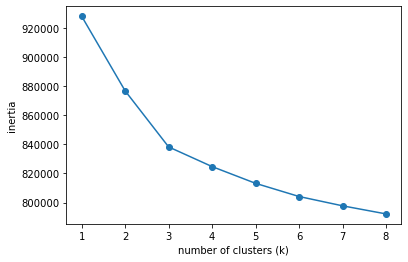

In [4]:
# explore how many number cluster can give a small enough inertia and also be as small number as possible
kmeans_cluster_opt(binary_data)

The chart shows the number 3 is an "elbow" at the line chart, which means segmenting the participants into three clusters could return us a good number of groups and a low error as well.

In [5]:
# create a new column cluster segmenting participants
# As the chart indicates above, we choose to make 3 clusters
binary_data['cluster'] = kmeans_predict(binary_data , n_clusters = 3)[0]

In [193]:
clusters = ["cluster 0", "cluster 1", "cluster 2"]

## Analysis

First of all, let's take a look at how many participants per each cluster.

In [6]:
binary_data.groupby(['cluster']).size()

cluster
0    11301
1     6945
2     7727
dtype: int64

In [7]:
# Question and its number of columns
qs_num = {
    "Age" : [0,11],
    "Gender" : [11,16],
    "Country" : [16,82],
    "HighEdu" : [82,89],
    "Employment" : [89,104],
    "CodeExp" : [104,111],
    "ProgLangReg" : [111,125],
    "ProgLangRec" : [125,138],
    "IDE" : [138,151],
    "HostNotebook" : [151, 169],
    "CompPlatMost" : [169,175],
    "HardwareReg" : [175,182],
    "TPUtimes" : [182, 187],
    "VisualLib" : [187,200],
    "MLmethd" : [200,209],
    "MLframe" : [209,227],
    "MLalgorithm" : [227,239],
    "CompVis" : [239,246],
    "NLP" : [246,253],
    "Industry" : [253,272],
    "SizeEmployer" : [272,278],
    "SizeDS" : [278,287],
    "DSBusiness" : [287,292],
    "WorkAct" : [292,301],
    "Compensation" : [301,328],
    "InvestDS" : [328, 334],
    "CldCompPltReg" : [334,347],
    "CldCompPltBstExp" : [347,360],
    "CldCompProdReg" : [360,365],
    "DataStoreProdReg" : [365,373],
    "ManageMLProdReg" : [373,383],
    "BigDataProdReg" : [383,405],
    "BigDataProdMost" : [405,425],
    "IntegenceReg" : [425,443],
    "IntegenceMost" : [443,459],
    "IsAutoML" : [459,467],
    "AutoMLReg" : [467,475],
    "MLexperiment" : [475,487],
    "PubShare" : [487,497],
    "Courses" : [497,510],
    "PrimaryTool" : [510,516],
    "FavMedia" : [516,528],
    "CldCompPltNxt" : [528,540],
    "CldCompProdNxt" : [540,545],
    "DataStoreProdNxt" : [545,553],
    "ManageMLProdNxt" : [553,563],
    "BigDataProdNxt" : [563,584],
    "IntegenceNxt" : [584,601],
    "AutoMLCatNxt" : [601,609],
    "AutoMLProdNxt" : [609,617],
    "MLexperimentNxt" : [617,629]
}

In [112]:
edu_aggr = cluster_question_plot(binary_data, "HighEdu")[0]

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



C0 and C1 both have highest shares in the age group between 18 to 21, taking 24.9% and 25.4% respectively.
As the age group increases, the share drops.

C2 The highest share age group is 25-29, followed by 30-34 and 35-39, which indicates the C2 participants are more likely older than C0 and C1 cluster participants.

In [117]:
cols = edu_aggr.columns.tolist()

In [121]:
cols = [
 'cluster',
 'No formal education past high school',
 'Some college/university study without earning a bachelor’s degree',
 'Bachelor’s degree',
 'Master’s degree',
 'Professional doctorate',
 'Doctoral degree',
 'I prefer not to answer'
 ]

edu_aggr = edu_aggr[cols]

In [123]:
edu_aggr = edu_aggr.loc[edu_aggr['cluster'].isin([0,1,2])]

In [195]:
fig = make_subplots(rows=1, cols=3, 
                    start_cell="bottom-left", 
                    subplot_titles=(clusters))

clusters = edu_aggr.index.tolist()

options = edu_aggr.columns[1:]

colors = shades_blue

for c in range(len(clusters)):
    data = edu_aggr.loc[edu_aggr['cluster'] == clusters[c]]
    for o in range(len(options)):
        fig.add_trace(go.Bar(x=[options[o]], 
                             y=data[options[o]],
                             marker_color = colors[o]),
                              row=1, col=c+1)
        
fig.update_layout(showlegend=False)
fig.show()

In [12]:
cluster_question_plot(binary_data, "Gender")[0]

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,cluster,Man,Nonbinary,Prefer not to say,Prefer to self-describe,Woman
0,0,75.6,0.4,1.6,0.2,22.2
1,1,78.4,0.3,0.9,0.2,20.3
2,2,85.6,0.3,1.4,0.1,12.5
3,Total,79.3,0.3,1.4,0.2,18.8


All three clusters are male dominated. C2 has a relatively even higher share than C0 and C1 by over 7 percentage points. Correspondingly, the share of female participants of C2 is lower than 0 and 1.

In [13]:
developed_regions = ['cluster','Australia', 'Austria', 'Belgium',  'Canada',  
       'Denmark', 'France', 'Germany', 'Greece', 'Hong Kong (S.A.R.)',
       'Ireland', 'Israel', 'Italy', 'Japan', 'Netherlands', 'Norway', 'Portugal', 'Singapore',  'South Korea', 'Spain',
       'Sweden', 'Switzerland', 'Taiwan', 
       'United Kingdom of Great Britain and Northern Ireland',
       'United States of America']

BRICS = ['Brazil', 'China', 'India', 'Russia', 'South Africa'] 

In [14]:
cluster_question_plot(binary_data, "Country")[0][developed_regions]

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,cluster,Australia,Austria,Belgium,Canada,Denmark,France,Germany,Greece,Hong Kong (S.A.R.),...,Norway,Portugal,Singapore,South Korea,Spain,Sweden,Switzerland,Taiwan,United Kingdom of Great Britain and Northern Ireland,United States of America
0,0,1.0,0.2,0.2,1.2,0.2,1.4,1.6,0.3,0.3,...,0.2,0.4,0.6,1.6,1.5,0.2,0.2,1.3,1.9,9.5
1,1,0.7,0.1,0.2,1.1,0.1,1.0,1.3,0.4,0.3,...,0.1,0.5,0.9,0.9,1.6,0.3,0.1,1.2,1.7,7.5
2,2,1.4,0.3,0.3,1.6,0.3,2.2,2.5,0.5,0.4,...,0.2,0.5,0.7,1.6,2.3,0.5,0.4,1.4,2.8,13.7
3,Total,1.0,0.2,0.3,1.3,0.2,1.5,1.8,0.4,0.3,...,0.2,0.5,0.7,1.4,1.7,0.3,0.3,1.3,2.1,10.2


C2 participants are more likely to reside in developed countries. C0 has slight more number of participants than C1 residing in developed regions.

In [15]:
cluster_question_plot(binary_data, "Country")[0][BRICS]

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Brazil,China,India,Russia,South Africa
0,2.3,4.6,29.6,3.2,0.5
1,3.1,1.6,35.0,2.3,0.8
2,3.6,2.3,21.4,2.8,0.5
3,2.9,3.1,28.6,2.9,0.6


Expectedly, C2 don't have clearly more participants than any the other cluster in the BRICS countries, apart from Brazil. India is the biggest country that has the highest share of C1 cluster participants (35%), almost 5 times as the number as of the United States.

In [16]:
cluster_question_plot(binary_data, "HighEdu")[0]

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,cluster,Bachelor’s degree,Doctoral degree,I prefer not to answer,Master’s degree,No formal education past high school,Professional doctorate,Some college/university study without earning a bachelor’s degree
0,0,41.6,8.2,3.5,34.3,2.3,1.2,8.9
1,1,45.1,8.0,1.8,36.1,1.3,1.0,6.7
2,2,26.8,17.0,1.4,48.6,0.9,2.0,3.4
3,Total,38.1,10.8,2.4,39.0,1.6,1.4,6.7


C2 has the highest share of participants that will have Master’s degree, Professional doctorate	or Doctoral degree as the highest education level in the next 2 years.

In [17]:
cluster_question_plot(binary_data, "Employment")[0]

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,cluster,Business Analyst,Currently not employed,DBA/Database Engineer,Data Analyst,Data Engineer,Data Scientist,Developer Relations/Advocacy,Machine Learning Engineer,Other,Product Manager,Program/Project Manager,Research Scientist,Software Engineer,Statistician,Student
0,0,4.1,8.2,0.7,8.8,2.1,7.5,0.5,3.8,10.2,1.3,3.1,4.8,9.2,1.5,34.1
1,1,2.8,15.0,0.5,6.2,1.3,7.5,0.3,3.3,7.7,0.6,1.9,3.5,6.5,0.7,42.2
2,2,4.0,0.2,0.8,11.3,4.5,29.1,0.3,10.8,9.0,1.6,4.7,9.7,12.4,1.3,0.3
3,Total,3.7,7.6,0.7,8.9,2.6,13.9,0.4,5.8,9.2,1.2,3.3,5.9,9.4,1.2,26.2


Comparing C2 with C0 and C1 clusers, C2 has the highest, almost 4 times as any of the rest, share (~29.1%) of participants who are data scientists. On the other hand, C1 and 0 have highest shares of Unemployed and Students. 

In [18]:
cluster_question_plot(binary_data, "Industry")[0]

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,cluster,Academics/Education,Accounting/Finance,Broadcasting/Communications,Computers/Technology,Energy/Mining,Government/Public Service,Hospitality/Entertainment/Sports,Insurance/Risk Assessment,Manufacturing/Fabrication,Marketing/CRM,Medical/Pharmaceutical,Military/Security/Defense,Non-profit/Service,Online Business/Internet-based Sales,Online Service/Internet-based Services,Other,Retail/Sales,Shipping/Transportation,NaN
0,0,22.7,9.0,1.9,20.9,3.5,5.4,1.0,2.2,6.2,2.3,4.3,1.0,2.3,1.5,2.7,7.8,3.6,1.8,0.0
1,1,21.3,8.1,1.9,23.3,3.7,5.0,1.0,1.8,5.3,2.0,4.3,1.4,2.2,1.5,3.3,8.6,3.2,2.1,0.0
2,2,16.8,9.2,2.1,28.7,3.3,3.5,1.1,3.2,4.7,2.4,5.3,1.3,1.4,1.9,4.4,5.7,3.1,2.0,0.0
3,Total,19.7,8.9,2.0,25.0,3.4,4.4,1.1,2.6,5.3,2.3,4.8,1.2,1.8,1.7,3.6,7.0,3.3,1.9,0.0


Computer and Technology is the most popular industry for all of the clusters, C2 has the highest among the three, 5% and 8 percentage points higher than C1 and C0 respectively. On the other hand, the second most popular industry is Academia/Education. Even though cluster 2 has the highest share of master and doctor degree participants, its share that work in the Academia is comparatively lower. The third most popular industry is Finance/Accounting and the share of each cluster is actually close. 

In [19]:
cluster_question_plot(binary_data, "SizeEmployer")[0]

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,cluster,0-49 employees,"10,000 or more employees","1000-9,999 employees",250-999 employees,50-249 employees,NaN
0,0,35.2,18.9,17.9,12.7,15.3,0.0
1,1,33.1,20.0,17.5,12.8,16.6,0.0
2,2,27.4,23.0,20.0,13.8,15.8,0.0
3,Total,31.1,21.0,18.8,13.3,15.8,0.0


Small size comannies take the highest share of every cluster, whereas C2 participants are more likely to work in big companies than C0 and C1.

In [20]:
cluster_question_plot(binary_data, "SizeDS")[0]

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,cluster,0,1-2,10-14,15-19,20+,3-4,5-9,NaN,I do not know
0,0,23.8,17.8,3.7,1.5,14.3,10.4,6.8,0.0,21.7
1,1,23.5,18.4,3.8,1.6,15.4,12.2,7.8,0.0,17.3
2,2,6.7,21.1,7.2,3.2,24.7,16.9,13.3,0.0,6.9
3,Total,16.3,19.3,5.3,2.2,19.1,13.6,9.8,0.0,14.4


No surprise, C2 cluster has the higher share of data science colleagues at their employers than any other cluster. Over 40% of participants in either C0 or C1 have no idea how many people working in data scient or they claim none actually works at this field.

In [21]:
cluster_question_plot(binary_data, "DSBusiness")[0]

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,cluster,No (we do not use ML methods),We are exploring ML methods (and may one day put a model into production),"We have well established ML methods (i.e., models in production for more than 2 years)","We recently started using ML methods (i.e., models in production for less than 2 years)",We use ML methods for generating insights (but do not put working models into production)
0,0,41.8,26.3,11.5,9.8,10.7
1,1,37.9,25.8,12.6,12.8,10.9
2,2,11.1,25.2,26.8,22.2,14.8
3,Total,24.6,25.6,19.9,17.0,12.9


With a higher share of data science team, it's no doubt that C2 has also the highest share of participants that their employer deployed or adopted ML methods in the business.

In [22]:
cluster_question_plot(binary_data, "WorkAct")[0]

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,cluster,Q24_Part_1_Select any activities that make up an important part of your role at work: (Select all that apply) - Selected Choice - Analyze and understand data to influence product or business decisions,"Q24_Part_2_Select any activities that make up an important part of your role at work: (Select all that apply) - Selected Choice - Build and/or run the data infrastructure that my business uses for storing, analyzing, and operationalizing data",Q24_Part_3_Select any activities that make up an important part of your role at work: (Select all that apply) - Selected Choice - Build prototypes to explore applying machine learning to new areas,Q24_Part_4_Select any activities that make up an important part of your role at work: (Select all that apply) - Selected Choice - Build and/or run a machine learning service that operationally improves my product or workflows,Q24_Part_5_Select any activities that make up an important part of your role at work: (Select all that apply) - Selected Choice - Experimentation and iteration to improve existing ML models,Q24_Part_6_Select any activities that make up an important part of your role at work: (Select all that apply) - Selected Choice - Do research that advances the state of the art of machine learning,Q24_Part_7_Select any activities that make up an important part of your role at work: (Select all that apply) - Selected Choice - None of these activities are an important part of my role at work,Q24_OTHER_Select any activities that make up an important part of your role at work: (Select all that apply) - Selected Choice - Other,NaN
0,0,33.0,12.3,9.2,5.6,5.9,6.9,21.4,5.8,0.0
1,1,28.8,13.6,12.6,9.5,10.8,9.4,13.3,2.1,0.0
2,2,25.2,14.3,18.5,13.5,14.4,10.5,2.8,0.8,0.0
3,Total,27.5,13.8,15.5,11.1,12.0,9.5,8.5,2.0,0.0


With a strong background as data scientists in Cluster 2, it explains why they have higher shares of participants working at ML related activites. 

- Build prototypes to explore applying machine learning to new areas

- Build and/or run a machine learning service that operationally improves my product or workflows

- Experimentation and iteration to improve existing ML models

- Do research that advances the state of the art of machine learning

Interestingly, C0 has a higher share of participants working at 

- Analyze and understand data to influence product or business decisions

- None of these activities are an important part of my role at work

- Other

It could be they have a relatively higher participants working as business analyst / data analysts or other fields. They work closely with Data Scientists and have strong interest in this area. 

In [23]:
cluster_question_plot(binary_data, "Compensation")[0]

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,cluster,$0-999,"$500,000-999,999","1,000-1,999","10,000-14,999","100,000-124,999","125,000-149,999","15,000-19,999","150,000-199,999","2,000-2,999",...,"40,000-49,999","5,000-7,499","50,000-59,999","60,000-69,999","7,500-9,999","70,000-79,999","80,000-89,999","90,000-99,999",">$1,000,000",NaN
0,0,30.0,0.2,6.5,5.6,3.5,1.8,3.5,1.5,3.9,...,4.0,4.6,4.5,3.2,3.2,3.0,2.0,1.4,0.4,0.0
1,1,29.9,0.0,6.4,7.2,2.5,1.1,4.2,0.9,3.6,...,4.2,5.9,3.0,2.7,4.8,2.1,1.5,1.3,0.2,0.0
2,2,13.5,0.3,6.1,6.1,6.4,3.4,3.7,3.9,3.7,...,4.9,4.0,5.2,4.1,3.4,3.4,3.3,3.2,0.4,0.0
3,Total,21.9,0.2,6.3,6.2,4.7,2.5,3.7,2.5,3.7,...,4.5,4.5,4.5,3.6,3.6,3.0,2.5,2.3,0.4,0.0


C2 has higher percentage of participants earning at the higher end.

In [24]:
cluster_question_plot(binary_data, "InvestDS")[0]

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,cluster,$0 ($USD),$1-$99,"$10,000-$99,999","$100,000 or more ($USD)",$100-$999,"$1000-$9,999"
0,0,61.6,11.6,4.3,3.2,10.8,8.5
1,1,96.6,1.1,0.3,0.2,1.0,0.7
2,2,2.0,17.9,14.6,11.4,26.5,27.5
3,Total,38.9,12.7,8.6,6.7,16.7,16.4


C2 has intested a lot more than any other cluster. C1 has the lowest, could be they are most likely students or unemployed.

In [25]:
cluster_question_plot(binary_data, "CodeExp")[0]

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,cluster,1-3 years,10-20 years,20+ years,3-5 years,5-10 years,< 1 years,I have never written code
0,0,30.1,5.6,5.2,12.6,8.2,31.3,7.1
1,1,38.4,4.5,3.5,16.4,9.8,23.9,3.3
2,2,23.4,15.8,13.3,19.3,19.3,8.8,0.0
3,Total,30.3,8.3,7.2,15.6,11.9,22.6,4.0


C2 participants have coding experience more or less, it has the highest percentages of participants coding for over 5 years. On the other hand, C1 have fewer share of participants have no coding experience than the C0 and has a relatively higher share than the latter.

In [26]:
cluster_question_plot(binary_data, "ProgLangReg")[0]

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,cluster,Q7_Part_1_What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - Python,Q7_Part_2_What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - R,Q7_Part_3_What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - SQL,Q7_Part_4_What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - C,Q7_Part_5_What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - C++,Q7_Part_6_What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - Java,Q7_Part_7_What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - Javascript,Q7_Part_8_What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - Julia,Q7_Part_9_What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - Swift,Q7_Part_10_What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - Bash,Q7_Part_11_What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - MATLAB,Q7_Part_12_What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - None,Q7_OTHER_What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - Other,NaN
0,0,33.0,7.2,14.2,8.7,9.8,8.0,6.4,0.3,0.4,2.1,4.5,1.0,4.3,0.0
1,1,34.2,7.5,16.0,7.7,9.2,7.4,6.8,0.4,0.2,2.5,4.7,0.3,3.1,0.0
2,2,32.6,9.6,19.0,4.9,6.2,6.2,6.6,0.6,0.5,5.6,4.1,0.1,4.1,0.0
3,Total,33.2,8.1,16.3,7.1,8.4,7.2,6.6,0.5,0.4,3.4,4.5,0.5,3.9,0.0


Python is the most popular regular programming language, followed by SQL. The third regular programming languages differ that Cluster 2 favors R more, while C1 and C0 prefers C++. It could be the higher share of DS participants allocated in C2 and they are consumers of the R language for statistical modeling. On the other hand, as the role question suggested, software engineers take a noticeable share in C0 and C1 and they use C++ as regular language.

In [27]:
cluster_question_plot(binary_data, "ProgLangRec")[0]

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,cluster,Bash,C,C++,Java,Javascript,Julia,MATLAB,None,Other,Python,R,SQL,Swift
0,0,0.2,2.4,2.4,1.4,0.8,0.5,1.1,0.9,1.0,77.0,6.6,5.5,0.1
1,1,0.0,1.6,1.5,0.6,0.3,0.4,0.6,0.1,0.4,85.3,4.5,4.5,0.0
2,2,0.2,1.1,1.1,0.6,0.3,0.8,0.8,0.1,0.5,82.8,5.8,6.0,0.0
3,Total,0.2,1.8,1.8,1.0,0.5,0.5,0.9,0.4,0.7,81.0,5.8,5.4,0.1


No doubtedly, Python is the most popular language in the recommendation. But interestingly, even though C0 participants are the least group using R as regular language, they suggest it as the most recommending one, which indicates they are aware that this language is a must if you want to understand more of what data scientists do.

In [28]:
cluster_question_plot(binary_data, "MLmethd")[0]

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,cluster,1-2 years,10-20 years,2-3 years,20 or more years,3-4 years,4-5 years,5-10 years,I do not use machine learning methods,Under 1 year
0,0,12.5,0.7,5.0,0.6,2.2,1.6,1.6,32.7,43.2
1,1,24.2,0.5,8.1,0.3,3.1,1.8,1.6,10.8,49.6
2,2,24.4,3.4,16.8,1.7,9.9,8.7,10.0,1.5,23.4
3,Total,19.7,1.5,9.7,0.9,4.9,4.0,4.3,16.4,38.6


C0 has a lot more participants who don't use ML methods at all, 3 times and 30 times as C1 and C2.

In [29]:
cluster_question_plot(binary_data, "VisualLib")[0]

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,cluster,Q14_Part_1_What data visualization libraries or tools do you use on a regular basis? (Select all that apply) - Selected Choice - Matplotlib,Q14_Part_2_What data visualization libraries or tools do you use on a regular basis? (Select all that apply) - Selected Choice - Seaborn,Q14_Part_3_What data visualization libraries or tools do you use on a regular basis? (Select all that apply) - Selected Choice - Plotly / Plotly Express,Q14_Part_4_What data visualization libraries or tools do you use on a regular basis? (Select all that apply) - Selected Choice - Ggplot / ggplot2,Q14_Part_5_What data visualization libraries or tools do you use on a regular basis? (Select all that apply) - Selected Choice - Shiny,Q14_Part_6_What data visualization libraries or tools do you use on a regular basis? (Select all that apply) - Selected Choice - D3 js,Q14_Part_7_What data visualization libraries or tools do you use on a regular basis? (Select all that apply) - Selected Choice - Altair,Q14_Part_8_What data visualization libraries or tools do you use on a regular basis? (Select all that apply) - Selected Choice - Bokeh,Q14_Part_9_What data visualization libraries or tools do you use on a regular basis? (Select all that apply) - Selected Choice - Geoplotlib,Q14_Part_10_What data visualization libraries or tools do you use on a regular basis? (Select all that apply) - Selected Choice - Leaflet / Folium,Q14_Part_11_What data visualization libraries or tools do you use on a regular basis? (Select all that apply) - Selected Choice - None,Q14_OTHER_What data visualization libraries or tools do you use on a regular basis? (Select all that apply) - Selected Choice - Other,NaN
0,0,35.9,20.0,7.4,9.0,1.9,1.4,0.4,1.0,1.7,0.8,18.0,2.6,0.0
1,1,36.8,28.8,11.5,9.7,1.8,1.4,0.4,1.6,2.1,1.2,3.7,1.0,0.0
2,2,32.0,25.2,14.1,11.1,3.7,2.7,0.9,3.2,2.8,2.0,1.1,1.1,0.0
3,Total,34.6,24.8,11.4,10.0,2.6,1.9,0.6,2.1,2.3,1.4,6.8,1.5,0.0


C2 cluster has a wider option in visualization tools

In [30]:
cluster_question_plot(binary_data, "MLframe")[0]

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,cluster,Q16_Part_1_Which of the following machine learning frameworks do you use on a regular basis? (Select all that apply) - Selected Choice - Scikit-learn,Q16_Part_2_Which of the following machine learning frameworks do you use on a regular basis? (Select all that apply) - Selected Choice - TensorFlow,Q16_Part_3_Which of the following machine learning frameworks do you use on a regular basis? (Select all that apply) - Selected Choice - Keras,Q16_Part_4_Which of the following machine learning frameworks do you use on a regular basis? (Select all that apply) - Selected Choice - PyTorch,Q16_Part_5_Which of the following machine learning frameworks do you use on a regular basis? (Select all that apply) - Selected Choice - Fast.ai,Q16_Part_6_Which of the following machine learning frameworks do you use on a regular basis? (Select all that apply) - Selected Choice - MXNet,Q16_Part_7_Which of the following machine learning frameworks do you use on a regular basis? (Select all that apply) - Selected Choice - Xgboost,Q16_Part_8_Which of the following machine learning frameworks do you use on a regular basis? (Select all that apply) - Selected Choice - LightGBM,Q16_Part_9_Which of the following machine learning frameworks do you use on a regular basis? (Select all that apply) - Selected Choice - CatBoost,Q16_Part_10_Which of the following machine learning frameworks do you use on a regular basis? (Select all that apply) - Selected Choice - Prophet,Q16_Part_11_Which of the following machine learning frameworks do you use on a regular basis? (Select all that apply) - Selected Choice - H2O 3,Q16_Part_12_Which of the following machine learning frameworks do you use on a regular basis? (Select all that apply) - Selected Choice - Caret,Q16_Part_13_Which of the following machine learning frameworks do you use on a regular basis? (Select all that apply) - Selected Choice - Tidymodels,Q16_Part_14_Which of the following machine learning frameworks do you use on a regular basis? (Select all that apply) - Selected Choice - JAX,Q16_Part_15_Which of the following machine learning frameworks do you use on a regular basis? (Select all that apply) - Selected Choice - PyTorch Lightning,Q16_Part_16_Which of the following machine learning frameworks do you use on a regular basis? (Select all that apply) - Selected Choice - Huggingface,Q16_Part_17_Which of the following machine learning frameworks do you use on a regular basis? (Select all that apply) - Selected Choice - None,Q16_OTHER_Which of the following machine learning frameworks do you use on a regular basis? (Select all that apply) - Selected Choice - Other
0,0,27.7,16.3,12.3,10.9,0.9,0.3,6.8,2.5,1.6,0.7,0.6,1.4,1.2,0.4,1.5,0.9,12.2,1.6
1,1,27.0,18.1,15.6,10.0,1.2,0.3,11.4,4.4,2.7,0.9,0.5,1.4,0.9,0.1,1.5,1.6,2.1,0.4
2,2,22.3,15.8,14.0,11.3,1.9,0.6,11.6,5.8,3.1,2.0,1.2,2.2,1.4,0.4,2.3,2.7,0.8,0.7
3,Total,24.8,16.6,14.2,10.8,1.5,0.4,10.6,4.7,2.7,1.4,0.9,1.8,1.2,0.3,1.9,2.0,3.4,0.8


C2 cluster has a wider option in ML framework

In [31]:
cluster_question_plot(binary_data, "MLalgorithm")[0]

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,cluster,Q17_Part_1_Which of the following ML algorithms do you use on a regular basis? (Select all that apply): - Selected Choice - Linear or Logistic Regression,Q17_Part_2_Which of the following ML algorithms do you use on a regular basis? (Select all that apply): - Selected Choice - Decision Trees or Random Forests,"Q17_Part_3_Which of the following ML algorithms do you use on a regular basis? (Select all that apply): - Selected Choice - Gradient Boosting Machines (xgboost, lightgbm, etc)",Q17_Part_4_Which of the following ML algorithms do you use on a regular basis? (Select all that apply): - Selected Choice - Bayesian Approaches,Q17_Part_5_Which of the following ML algorithms do you use on a regular basis? (Select all that apply): - Selected Choice - Evolutionary Approaches,"Q17_Part_6_Which of the following ML algorithms do you use on a regular basis? (Select all that apply): - Selected Choice - Dense Neural Networks (MLPs, etc)",Q17_Part_7_Which of the following ML algorithms do you use on a regular basis? (Select all that apply): - Selected Choice - Convolutional Neural Networks,Q17_Part_8_Which of the following ML algorithms do you use on a regular basis? (Select all that apply): - Selected Choice - Generative Adversarial Networks,Q17_Part_9_Which of the following ML algorithms do you use on a regular basis? (Select all that apply): - Selected Choice - Recurrent Neural Networks,"Q17_Part_10_Which of the following ML algorithms do you use on a regular basis? (Select all that apply): - Selected Choice - Transformer Networks (BERT, gpt-3, etc)",Q17_Part_11_Which of the following ML algorithms do you use on a regular basis? (Select all that apply): - Selected Choice - None,Q17_OTHER_Which of the following ML algorithms do you use on a regular basis? (Select all that apply): - Selected Choice - Other
0,0,26.4,19.7,8.7,6.5,1.6,6.1,11.2,1.5,5.4,2.2,9.0,1.6
1,1,24.2,21.2,12.9,7.0,1.2,7.3,12.6,2.1,6.6,3.0,1.5,0.5
2,2,20.8,18.6,13.9,7.8,1.8,8.0,12.5,2.7,7.9,4.9,0.4,0.7
3,Total,23.0,19.7,12.5,7.3,1.6,7.4,12.3,2.2,7.0,3.8,2.4,0.8


C2 cluster has a wider option in ML algorithms

In [32]:
cluster_question_plot(binary_data, "CompVis")[0]

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,cluster,"Q18_Part_1_Which categories of computer vision methods do you use on a regular basis? (Select all that apply) - Selected Choice - General purpose image/video tools (PIL, cv2, skimage, etc)","Q18_Part_2_Which categories of computer vision methods do you use on a regular basis? (Select all that apply) - Selected Choice - Image segmentation methods (U-Net, Mask R-CNN, etc)","Q18_Part_3_Which categories of computer vision methods do you use on a regular basis? (Select all that apply) - Selected Choice - Object detection methods (YOLOv3, RetinaNet, etc)","Q18_Part_4_Which categories of computer vision methods do you use on a regular basis? (Select all that apply) - Selected Choice - Image classification and other general purpose networks (VGG, Inception, ResNet, ResNeXt, NASNet, EfficientNet, etc)","Q18_Part_5_Which categories of computer vision methods do you use on a regular basis? (Select all that apply) - Selected Choice - Generative Networks (GAN, VAE, etc)",Q18_Part_6_Which categories of computer vision methods do you use on a regular basis? (Select all that apply) - Selected Choice - None,Q18_OTHER_Which categories of computer vision methods do you use on a regular basis? (Select all that apply) - Selected Choice - Other
0,0,15.3,15.4,16.0,27.6,8.8,15.8,1.1
1,1,17.1,17.3,17.2,29.1,9.3,9.4,0.6
2,2,17.6,18.4,18.0,27.7,10.0,7.6,0.8
3,Total,17.1,17.6,17.5,28.1,9.6,9.3,0.8


C1 and C2 have similar level of computer vision interests.

In [33]:
cluster_question_plot(binary_data, "NLP")[0]

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,cluster,"Q19_Part_1_Which of the following natural language processing (NLP) methods do you use on a regular basis? (Select all that apply) - Selected Choice - Word embeddings/vectors (GLoVe, fastText, word2vec)","Q19_Part_2_Which of the following natural language processing (NLP) methods do you use on a regular basis? (Select all that apply) - Selected Choice - Encoder-decorder models (seq2seq, vanilla transformers)","Q19_Part_3_Which of the following natural language processing (NLP) methods do you use on a regular basis? (Select all that apply) - Selected Choice - Contextualized embeddings (ELMo, CoVe)","Q19_Part_4_Which of the following natural language processing (NLP) methods do you use on a regular basis? (Select all that apply) - Selected Choice - Transformer language models (GPT-3, BERT, XLnet, etc)",Q19_Part_5_Which of the following natural language processing (NLP) methods do you use on a regular basis? (Select all that apply) - Selected Choice - None,Q19_OTHER_Which of the following natural language processing (NLP) methods do you use on a regular basis? (Select all that apply) - Selected Choice - Other,NaN
0,0,20.5,20.1,4.4,20.0,32.7,2.2,0.0
1,1,29.5,22.0,7.5,23.8,16.1,1.2,0.0
2,2,29.7,22.3,9.1,27.3,10.6,1.0,0.0
3,Total,28.7,22.0,8.1,25.5,14.5,1.2,0.0


C2 and C1 have far more shares of participants using NLP methods than C0. C2 has clearly more than C1 in Contextualized embeddings (ELMo, CoVe) and Transformer language models (GPT-3, BERT, XLnet, etc) which are less popular methods overall.

In [34]:
cluster_question_plot(binary_data, "PubShare")[0]

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,cluster,Q39_Part_1_Where do you publicly share your data analysis or machine learning applications? (Select all that apply) - Selected Choice - Plotly Dash,Q39_Part_2_Where do you publicly share your data analysis or machine learning applications? (Select all that apply) - Selected Choice - Streamlit,Q39_Part_3_Where do you publicly share your data analysis or machine learning applications? (Select all that apply) - Selected Choice - NBViewer,Q39_Part_4_Where do you publicly share your data analysis or machine learning applications? (Select all that apply) - Selected Choice - GitHub,Q39_Part_5_Where do you publicly share your data analysis or machine learning applications? (Select all that apply) - Selected Choice - Personal blog,Q39_Part_6_Where do you publicly share your data analysis or machine learning applications? (Select all that apply) - Selected Choice - Kaggle,Q39_Part_7_Where do you publicly share your data analysis or machine learning applications? (Select all that apply) - Selected Choice - Colab,Q39_Part_8_Where do you publicly share your data analysis or machine learning applications? (Select all that apply) - Selected Choice - Shiny,Q39_Part_9_Where do you publicly share your data analysis or machine learning applications? (Select all that apply) - Selected Choice - I do not share my work publicly,Q39_OTHER_Where do you publicly share your data analysis or machine learning applications? (Select all that apply) - Selected Choice - Other
0,0,1.3,0.8,0.7,20.2,2.8,15.2,3.3,2.1,49.8,3.8
1,1,1.2,0.6,0.6,23.5,2.8,21.9,5.2,1.5,40.7,1.9
2,2,2.1,3.0,1.0,32.9,5.1,21.6,14.1,2.1,16.3,1.8
3,Total,2.0,2.6,0.9,31.0,4.8,20.7,12.5,2.1,21.4,2.1


C2 has a very high willing to share their work and knowledge publicly. However, the are a bit less likely to share on Kaggle than C1.

In [35]:
cluster_question_plot(binary_data, "Courses")[0]

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,cluster,Q40_Part_1_On which platforms have you begun or completed data science courses? (Select all that apply) - Selected Choice - Coursera,Q40_Part_2_On which platforms have you begun or completed data science courses? (Select all that apply) - Selected Choice - edX,Q40_Part_3_On which platforms have you begun or completed data science courses? (Select all that apply) - Selected Choice - Kaggle Learn Courses,Q40_Part_4_On which platforms have you begun or completed data science courses? (Select all that apply) - Selected Choice - DataCamp,Q40_Part_5_On which platforms have you begun or completed data science courses? (Select all that apply) - Selected Choice - Fast.ai,Q40_Part_6_On which platforms have you begun or completed data science courses? (Select all that apply) - Selected Choice - Udacity,Q40_Part_7_On which platforms have you begun or completed data science courses? (Select all that apply) - Selected Choice - Udemy,Q40_Part_8_On which platforms have you begun or completed data science courses? (Select all that apply) - Selected Choice - LinkedIn Learning,"Q40_Part_9_On which platforms have you begun or completed data science courses? (Select all that apply) - Selected Choice - Cloud-certification programs (direct from AWS, Azure, GCP, or similar)",Q40_Part_10_On which platforms have you begun or completed data science courses? (Select all that apply) - Selected Choice - University Courses (resulting in a university degree),Q40_Part_11_On which platforms have you begun or completed data science courses? (Select all that apply) - Selected Choice - None,Q40_OTHER_On which platforms have you begun or completed data science courses? (Select all that apply) - Selected Choice - Other,NaN
0,0,18.0,5.9,18.1,7.3,1.3,3.9,12.3,5.2,2.0,9.4,10.4,6.1,0.0
1,1,19.7,5.9,19.9,8.5,2.2,5.9,13.0,5.7,4.2,9.6,1.6,3.9,0.0
2,2,20.5,6.6,15.5,8.3,3.0,6.5,13.6,5.5,4.0,10.5,2.2,3.7,0.0
3,Total,19.7,6.2,17.7,8.2,2.4,5.7,13.2,5.5,3.7,10.0,3.6,4.2,0.0


C1 and C2 are more likely to choose online courses than C0. Compared with C1, C2 participants are less into Kaggle courses.

In [36]:
cluster_question_plot(binary_data, "FavMedia")[0]

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,cluster,Q42_Part_1_Who/what are your favorite media sources that report on data science topics? (Select all that apply) - Selected Choice - Twitter (data science influencers),"Q42_Part_2_Who/what are your favorite media sources that report on data science topics? (Select all that apply) - Selected Choice - Email newsletters (Data Elixir, O'Reilly Data & AI, etc)","Q42_Part_3_Who/what are your favorite media sources that report on data science topics? (Select all that apply) - Selected Choice - Reddit (r/machinelearning, etc)","Q42_Part_4_Who/what are your favorite media sources that report on data science topics? (Select all that apply) - Selected Choice - Kaggle (notebooks, forums, etc)","Q42_Part_5_Who/what are your favorite media sources that report on data science topics? (Select all that apply) - Selected Choice - Course Forums (forums.fast.ai, Coursera forums, etc)","Q42_Part_6_Who/what are your favorite media sources that report on data science topics? (Select all that apply) - Selected Choice - YouTube (Kaggle YouTube, Cloud AI Adventures, etc)","Q42_Part_7_Who/what are your favorite media sources that report on data science topics? (Select all that apply) - Selected Choice - Podcasts (Chai Time Data Science, O’Reilly Data Show, etc)","Q42_Part_8_Who/what are your favorite media sources that report on data science topics? (Select all that apply) - Selected Choice - Blogs (Towards Data Science, Analytics Vidhya, etc)","Q42_Part_9_Who/what are your favorite media sources that report on data science topics? (Select all that apply) - Selected Choice - Journal Publications (peer-reviewed journals, conference proceedings, etc)","Q42_Part_10_Who/what are your favorite media sources that report on data science topics? (Select all that apply) - Selected Choice - Slack Communities (ods.ai, kagglenoobs, etc)",Q42_Part_11_Who/what are your favorite media sources that report on data science topics? (Select all that apply) - Selected Choice - None,Q42_OTHER_Who/what are your favorite media sources that report on data science topics? (Select all that apply) - Selected Choice - Other
0,0,6.5,6.5,5.4,22.0,5.1,23.0,3.4,11.6,5.2,3.0,6.5,1.9
1,1,7.1,6.3,5.9,22.6,6.7,21.2,3.9,15.6,5.4,3.9,0.6,0.8
2,2,7.7,7.0,5.6,21.3,5.3,17.8,4.2,16.9,7.9,4.2,1.1,1.1
3,Total,7.2,6.6,5.7,21.9,5.8,20.1,3.9,15.4,6.5,3.8,1.9,1.1


C1 and C2 are more likely to choose data science media than C0. C2 participants are more into Email, newsletter, podcasts and journals. C0 and C1 are more into Youtube and Kaggle.

In [37]:
cluster_question_plot(binary_data, "IDE")[0]

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,cluster,"Q9_Part_1_Which of the following integrated development environments (IDE's) do you use on a regular basis? (Select all that apply) - Selected Choice - Jupyter (JupyterLab, Jupyter Notebooks, etc)",Q9_Part_2_Which of the following integrated development environments (IDE's) do you use on a regular basis? (Select all that apply) - Selected Choice - RStudio,Q9_Part_3_Which of the following integrated development environments (IDE's) do you use on a regular basis? (Select all that apply) - Selected Choice - Visual Studio,Q9_Part_4_Which of the following integrated development environments (IDE's) do you use on a regular basis? (Select all that apply) - Selected Choice - Visual Studio Code (VSCode),Q9_Part_5_Which of the following integrated development environments (IDE's) do you use on a regular basis? (Select all that apply) - Selected Choice - PyCharm,Q9_Part_6_Which of the following integrated development environments (IDE's) do you use on a regular basis? (Select all that apply) - Selected Choice - Spyder,Q9_Part_7_Which of the following integrated development environments (IDE's) do you use on a regular basis? (Select all that apply) - Selected Choice - Notepad++,Q9_Part_8_Which of the following integrated development environments (IDE's) do you use on a regular basis? (Select all that apply) - Selected Choice - Sublime Text,Q9_Part_9_Which of the following integrated development environments (IDE's) do you use on a regular basis? (Select all that apply) - Selected Choice - Vim / Emacs,Q9_Part_10_Which of the following integrated development environments (IDE's) do you use on a regular basis? (Select all that apply) - Selected Choice - MATLAB,Q9_Part_11_Which of the following integrated development environments (IDE's) do you use on a regular basis? (Select all that apply) - Selected Choice - Jupyter Notebook,Q9_Part_12_Which of the following integrated development environments (IDE's) do you use on a regular basis? (Select all that apply) - Selected Choice - None,Q9_OTHER_Which of the following integrated development environments (IDE's) do you use on a regular basis? (Select all that apply) - Selected Choice - Other
0,0,6.6,7.1,7.9,15.8,12.5,5.3,6.3,4.3,1.9,4.1,23.5,1.9,2.8
1,1,8.4,6.9,5.6,16.3,11.1,6.3,5.2,4.7,1.8,3.5,27.6,0.3,2.2
2,2,10.5,8.1,5.5,14.8,11.1,6.1,6.6,4.3,3.8,2.6,24.8,0.1,1.9
3,Total,8.5,7.4,6.4,15.6,11.6,5.9,6.1,4.4,2.6,3.4,25.1,0.8,2.3


What is the main difference among each IDE? - Maybe closely with the knowledge and skillset?

In [38]:
cluster_question_plot(binary_data, "HostNotebook")[0]

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,cluster,Q10_Part_1_Which of the following hosted notebook products do you use on a regular basis? (Select all that apply) - Selected Choice - Kaggle Notebooks,Q10_Part_2_Which of the following hosted notebook products do you use on a regular basis? (Select all that apply) - Selected Choice - Colab Notebooks,Q10_Part_3_Which of the following hosted notebook products do you use on a regular basis? (Select all that apply) - Selected Choice - Azure Notebooks,Q10_Part_4_Which of the following hosted notebook products do you use on a regular basis? (Select all that apply) - Selected Choice - Paperspace / Gradient,Q10_Part_5_Which of the following hosted notebook products do you use on a regular basis? (Select all that apply) - Selected Choice - Binder / JupyterHub,Q10_Part_6_Which of the following hosted notebook products do you use on a regular basis? (Select all that apply) - Selected Choice - Code Ocean,Q10_Part_7_Which of the following hosted notebook products do you use on a regular basis? (Select all that apply) - Selected Choice - IBM Watson Studio,Q10_Part_8_Which of the following hosted notebook products do you use on a regular basis? (Select all that apply) - Selected Choice - Amazon Sagemaker Studio Notebooks,Q10_Part_9_Which of the following hosted notebook products do you use on a regular basis? (Select all that apply) - Selected Choice - Amazon EMR Notebooks,Q10_Part_10_Which of the following hosted notebook products do you use on a regular basis? (Select all that apply) - Selected Choice - Google Cloud Notebooks (AI Platform / Vertex AI),Q10_Part_11_Which of the following hosted notebook products do you use on a regular basis? (Select all that apply) - Selected Choice - Google Cloud Datalab,Q10_Part_12_Which of the following hosted notebook products do you use on a regular basis? (Select all that apply) - Selected Choice - Databricks Collaborative Notebooks,Q10_Part_13_Which of the following hosted notebook products do you use on a regular basis? (Select all that apply) - Selected Choice - Zeppelin / Zepl Notebooks,Q10_Part_14_Which of the following hosted notebook products do you use on a regular basis? (Select all that apply) - Selected Choice - Deepnote Notebooks,Q10_Part_15_Which of the following hosted notebook products do you use on a regular basis? (Select all that apply) - Selected Choice - Observable Notebooks,Q10_Part_16_Which of the following hosted notebook products do you use on a regular basis? (Select all that apply) - Selected Choice - None,Q10_OTHER_Which of the following hosted notebook products do you use on a regular basis? (Select all that apply) - Selected Choice - Other,NaN
0,0,21.3,19.5,2.0,0.5,4.3,0.6,2.1,0.9,0.8,4.6,4.7,0.8,0.5,0.6,0.4,33.7,2.8,0.0
1,1,31.1,31.4,2.1,0.5,4.9,0.3,3.5,1.1,0.4,5.2,4.3,0.8,0.3,0.6,0.3,11.6,1.4,0.0
2,2,24.3,27.8,4.1,0.7,4.9,0.5,3.0,3.8,1.4,6.4,5.2,2.9,1.2,0.9,0.5,11.0,1.6,0.0
3,Total,25.2,26.0,2.8,0.6,4.7,0.5,2.8,2.0,0.9,5.4,4.8,1.6,0.7,0.7,0.4,19.0,2.0,0.0


company (work) related?

needs to figure out the difference

In [39]:
cluster_question_plot(binary_data, "CompPlatMost")[0]

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,cluster,"A cloud computing platform (AWS, Azure, GCP, hosted notebooks, etc)","A deep learning workstation (NVIDIA GTX, LambdaLabs, etc)",A laptop,A personal computer / desktop,None,Other
0,0,4.6,1.9,69.5,21.1,2.1,0.6
1,1,7.6,2.2,71.6,17.6,0.5,0.5
2,2,17.3,6.1,55.3,20.2,0.1,1.0
3,Total,9.4,3.3,65.7,19.9,1.0,0.7


C2 have more in cloud computing platform and deep learning workstation

In [40]:
cluster_question_plot(binary_data, "HardwareReg")[0]

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,cluster,Q12_Part_1_Which types of specialized hardware do you use on a regular basis? (Select all that apply) - Selected Choice - NVIDIA GPUs,Q12_Part_2_Which types of specialized hardware do you use on a regular basis? (Select all that apply) - Selected Choice - Google Cloud TPUs,Q12_Part_3_Which types of specialized hardware do you use on a regular basis? (Select all that apply) - Selected Choice - AWS Trainium Chips,Q12_Part_4_Which types of specialized hardware do you use on a regular basis? (Select all that apply) - Selected Choice - AWS Inferentia Chips,Q12_Part_5_Which types of specialized hardware do you use on a regular basis? (Select all that apply) - Selected Choice - None,Q12_OTHER_Which types of specialized hardware do you use on a regular basis? (Select all that apply) - Selected Choice - Other,NaN
0,0,23.9,9.2,1.5,1.4,60.1,3.9,0.0
1,1,29.7,14.6,1.0,1.0,50.5,3.2,0.0
2,2,38.9,16.5,2.1,2.2,37.6,2.6,0.0
3,Total,30.4,13.1,1.6,1.6,50.1,3.3,0.0


C2 have more in NVIDIA GPU and Google Cloud TPU than C1 or C0.

In [41]:
cluster_question_plot(binary_data, "TPUtimes")[0]

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,cluster,2-5 times,6-25 times,More than 25 times,Never,Once
0,0,7.8,1.6,1.3,80.2,9.1
1,1,14.6,4.1,1.9,65.5,13.8
2,2,21.3,6.7,4.5,52.6,14.9
3,Total,14.0,3.9,2.5,67.4,12.2


More times of C2 than C0 or C1

In [42]:
cluster_question_plot(binary_data, "CldCompPltReg")[0]

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,cluster,Q27_A_Part_1_Which of the following cloud computing platforms do you use on a regular basis? (Select all that apply) - Selected Choice - Amazon Web Services (AWS),Q27_A_Part_2_Which of the following cloud computing platforms do you use on a regular basis? (Select all that apply) - Selected Choice - Microsoft Azure,Q27_A_Part_3_Which of the following cloud computing platforms do you use on a regular basis? (Select all that apply) - Selected Choice - Google Cloud Platform (GCP),Q27_A_Part_4_Which of the following cloud computing platforms do you use on a regular basis? (Select all that apply) - Selected Choice - IBM Cloud / Red Hat,Q27_A_Part_5_Which of the following cloud computing platforms do you use on a regular basis? (Select all that apply) - Selected Choice - Oracle Cloud,Q27_A_Part_6_Which of the following cloud computing platforms do you use on a regular basis? (Select all that apply) - Selected Choice - SAP Cloud,Q27_A_Part_7_Which of the following cloud computing platforms do you use on a regular basis? (Select all that apply) - Selected Choice - Salesforce Cloud,Q27_A_Part_8_Which of the following cloud computing platforms do you use on a regular basis? (Select all that apply) - Selected Choice - VMware Cloud,Q27_A_Part_9_Which of the following cloud computing platforms do you use on a regular basis? (Select all that apply) - Selected Choice - Alibaba Cloud,Q27_A_Part_10_Which of the following cloud computing platforms do you use on a regular basis? (Select all that apply) - Selected Choice - Tencent Cloud,Q27_A_Part_11_Which of the following cloud computing platforms do you use on a regular basis? (Select all that apply) - Selected Choice - None,Q27_A_OTHER_Which of the following cloud computing platforms do you use on a regular basis? (Select all that apply) - Selected Choice - Other,NaN
0,0,13.7,11.9,13.0,3.2,3.7,2.6,1.9,2.6,2.2,1.5,40.5,3.1,0.0
1,1,16.0,13.2,16.0,3.3,3.8,2.3,1.5,2.8,0.5,0.5,39.4,0.5,0.0
2,2,27.9,17.7,23.2,4.0,2.9,1.8,1.9,2.6,1.7,1.1,12.9,2.2,0.0
3,Total,25.2,16.6,21.3,3.9,3.1,2.0,1.9,2.6,1.8,1.2,18.2,2.3,0.0


AWS,Micosoft Azure, and GCP - C2

In [43]:
cluster_question_plot(binary_data, "CldCompPltBstExp")[0]

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,cluster,Alibaba Cloud,Amazon Web Services (AWS),Google Cloud Platform (GCP),IBM Cloud / Red Hat,Microsoft Azure,Oracle Cloud,SAP Cloud,Salesforce Cloud,Tencent Cloud,VMware Cloud,None were satisfactory,Other,They all had a similarly enjoyable developer experience
0,0,2.9,21.5,15.3,4.0,11.3,6.6,2.2,1.5,1.1,1.5,5.8,1.1,25.2
1,1,0.0,25.0,33.9,0.0,10.7,3.6,1.8,0.0,0.0,0.0,1.8,0.0,23.2
2,2,0.9,27.3,24.2,2.6,14.9,1.4,0.6,0.7,0.4,0.9,2.8,1.0,22.3
3,Total,1.1,26.7,23.6,2.7,14.5,1.9,0.7,0.7,0.4,1.0,3.0,1.0,22.6


In [44]:
cluster_question_plot(binary_data, "CldCompProdReg")[0]

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,cluster,Q29_A_Part_1_Do you use any of the following cloud computing products on a regular basis? (Select all that apply) - Selected Choice - Amazon Elastic Compute Cloud (EC2),Q29_A_Part_2_Do you use any of the following cloud computing products on a regular basis? (Select all that apply) - Selected Choice - Microsoft Azure Virtual Machines,Q29_A_Part_3_Do you use any of the following cloud computing products on a regular basis? (Select all that apply) - Selected Choice - Google Cloud Compute Engine,Q29_A_Part_4_Do you use any of the following cloud computing products on a regular basis? (Select all that apply) - Selected Choice - No / None,Q29_A_OTHER_Do you use any of the following cloud computing products on a regular basis? (Select all that apply) - Selected Choice - Other
0,0,20.0,19.4,19.9,39.6,1.0
1,1,22.6,12.8,18.8,44.4,1.5
2,2,31.1,19.9,26.6,21.1,1.3
3,Total,29.8,19.7,25.7,23.5,1.3


In [45]:
cluster_question_plot(binary_data, "DataStoreProdReg")[0]

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,cluster,Q30_A_Part_1_Do you use any of the following data storage products on a regular basis? (Select all that apply) - Selected Choice - Microsoft Azure Data Lake Storage,Q30_A_Part_2_Do you use any of the following data storage products on a regular basis? (Select all that apply) - Selected Choice - Microsoft Azure Disk Storage,Q30_A_Part_3_Do you use any of the following data storage products on a regular basis? (Select all that apply) - Selected Choice - Amazon Simple Storage Service (S3),Q30_A_Part_4_Do you use any of the following data storage products on a regular basis? (Select all that apply) - Selected Choice - Amazon Elastic File System (EFS),Q30_A_Part_5_Do you use any of the following data storage products on a regular basis? (Select all that apply) - Selected Choice - Google Cloud Storage (GCS),Q30_A_Part_6_Do you use any of the following data storage products on a regular basis? (Select all that apply) - Selected Choice - Google Cloud Filestore,Q30_A_Part_7_Do you use any of the following data storage products on a regular basis? (Select all that apply) - Selected Choice - No / None,Q30_A_OTHER_Do you use any of the following data storage products on a regular basis? (Select all that apply) - Selected Choice - Other
0,0,8.5,9.1,15.5,5.2,20.0,10.4,29.6,1.7
1,1,7.4,9.8,14.7,8.0,21.5,11.7,27.0,0.0
2,2,10.2,9.3,26.8,7.8,21.7,8.2,15.0,1.0
3,Total,10.0,9.3,25.5,7.6,21.5,8.5,16.7,1.0


In [46]:
cluster_question_plot(binary_data, "ManageMLProdReg")[0]

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,cluster,Q31_A_Part_1_Do you use any of the following managed machine learning products on a regular basis? (Select all that apply) - Selected Choice - Amazon SageMaker,Q31_A_Part_2_Do you use any of the following managed machine learning products on a regular basis? (Select all that apply) - Selected Choice - Azure Machine Learning Studio,Q31_A_Part_3_Do you use any of the following managed machine learning products on a regular basis? (Select all that apply) - Selected Choice - Google Cloud Vertex AI,Q31_A_Part_4_Do you use any of the following managed machine learning products on a regular basis? (Select all that apply) - Selected Choice - DataRobot,Q31_A_Part_5_Do you use any of the following managed machine learning products on a regular basis? (Select all that apply) - Selected Choice - Databricks,Q31_A_Part_6_Do you use any of the following managed machine learning products on a regular basis? (Select all that apply) - Selected Choice - Dataiku,Q31_A_Part_7_Do you use any of the following managed machine learning products on a regular basis? (Select all that apply) - Selected Choice - Alteryx,Q31_A_Part_8_Do you use any of the following managed machine learning products on a regular basis? (Select all that apply) - Selected Choice - Rapidminer,Q31_A_Part_9_Do you use any of the following managed machine learning products on a regular basis? (Select all that apply) - Selected Choice - No / None,Q31_A_OTHER_Do you use any of the following managed machine learning products on a regular basis? (Select all that apply) - Selected Choice - Other
0,0,2.4,3.7,4.5,3.0,2.9,1.1,1.7,1.7,74.7,4.2
1,1,3.3,5.4,6.0,0.7,3.7,0.7,1.3,1.3,77.6,0.0
2,2,10.5,9.6,6.8,3.0,8.5,2.0,2.4,2.9,52.1,2.1
3,Total,8.8,8.4,6.4,3.0,7.4,1.8,2.3,2.6,56.9,2.5


In [47]:
cluster_question_plot(binary_data, "BigDataProdReg")[0]

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,cluster,"Q32_A_Part_1_Which of the following big data products (relational databases, data warehouses, data lakes, or similar) do you use on a regular basis? (Select all that apply) - Selected Choice - MySQL","Q32_A_Part_2_Which of the following big data products (relational databases, data warehouses, data lakes, or similar) do you use on a regular basis? (Select all that apply) - Selected Choice - PostgreSQL","Q32_A_Part_3_Which of the following big data products (relational databases, data warehouses, data lakes, or similar) do you use on a regular basis? (Select all that apply) - Selected Choice - SQLite","Q32_A_Part_4_Which of the following big data products (relational databases, data warehouses, data lakes, or similar) do you use on a regular basis? (Select all that apply) - Selected Choice - Oracle Database","Q32_A_Part_5_Which of the following big data products (relational databases, data warehouses, data lakes, or similar) do you use on a regular basis? (Select all that apply) - Selected Choice - MongoDB","Q32_A_Part_6_Which of the following big data products (relational databases, data warehouses, data lakes, or similar) do you use on a regular basis? (Select all that apply) - Selected Choice - Snowflake","Q32_A_Part_7_Which of the following big data products (relational databases, data warehouses, data lakes, or similar) do you use on a regular basis? (Select all that apply) - Selected Choice - IBM Db2","Q32_A_Part_8_Which of the following big data products (relational databases, data warehouses, data lakes, or similar) do you use on a regular basis? (Select all that apply) - Selected Choice - Microsoft SQL Server","Q32_A_Part_9_Which of the following big data products (relational databases, data warehouses, data lakes, or similar) do you use on a regular basis? (Select all that apply) - Selected Choice - Microsoft Azure SQL Database",...,"Q32_A_Part_13_Which of the following big data products (relational databases, data warehouses, data lakes, or similar) do you use on a regular basis? (Select all that apply) - Selected Choice - Amazon RDS","Q32_A_Part_14_Which of the following big data products (relational databases, data warehouses, data lakes, or similar) do you use on a regular basis? (Select all that apply) - Selected Choice - Amazon DynamoDB","Q32_A_Part_15_Which of the following big data products (relational databases, data warehouses, data lakes, or similar) do you use on a regular basis? (Select all that apply) - Selected Choice - Google Cloud BigQuery","Q32_A_Part_16_Which of the following big data products (relational databases, data warehouses, data lakes, or similar) do you use on a regular basis? (Select all that apply) - Selected Choice - Google Cloud SQL","Q32_A_Part_17_Which of the following big data products (relational databases, data warehouses, data lakes, or similar) do you use on a regular basis? (Select all that apply) - Selected Choice - Google Cloud Firestore","Q32_A_Part_18_Which of the following big data products (relational databases, data warehouses, data lakes, or similar) do you use on a regular basis? (Select all that apply) - Selected Choice - Google Cloud BigTable","Q32_A_Part_19_Which of the following big data products (relational databases, data warehouses, data lakes, or similar) do you use on a regular basis? (Select all that apply) - Selected Choice - Google Cloud Spanner","Q32_A_Part_20_Which of the following big data products (relational databases, data warehouses, data lakes, or similar) do you use on a regular basis? (Select all that apply) - Selected Choice - None","Q32_A_OTHER_Which of the following big data products (relational databases, data warehouses, data lakes, or similar) do you use on a regular basis? (Select all that apply) - Selected Choice - Other",NaN
0,0,17.1,7.2,5.3,5.3,4.3,1.5,1.9,9.6,2.5,...,1.9,0.9,2.8,1.9,1.3,0.9,0.9,28.9,2.3,0.0
1,1,18.0,8.8,6.8,5.1,7.6,1.0,1.6,9.6,3.1,...,1.4,1.6,3.9,3.5,1.0,0.6,0.6,21.7,0.4,0.0
2,2,16.9,11.3,8.2,5.2,8.4,2.5,1.6,8

C2 has more and wider options.

In [48]:
cluster_question_plot(binary_data, "BigDataProdMost")[0]

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,cluster,Amazon Aurora,Amazon DynamoDB,Amazon RDS,Amazon Redshift,Google Cloud BigQuery,Google Cloud BigTable,Google Cloud Firestore,Google Cloud SQL,Google Cloud Spanner,...,Microsoft Azure Cosmos DB,Microsoft Azure SQL Database,Microsoft SQL Server,MongoDB,MySQL,Oracle Database,Other,PostgreSQL,SQLite,Snowflake
0,0,0.4,1.8,2.0,1.1,5.2,0.7,1.3,2.7,0.2,...,1.8,4.7,16.6,3.4,24.9,10.1,1.1,11.7,6.3,2.0
1,1,1.1,0.0,0.0,2.2,7.6,0.0,0.0,2.2,0.0,...,0.0,3.3,25.0,4.3,29.3,7.6,0.0,10.9,4.3,1.1
2,2,0.8,1.7,2.1,3.4,6.5,0.7,1.3,1.6,0.2,...,1.1,4.1,12.5,7.8,23.6,6.4,1.4,15.3,4.9,3.0
3,Total,0.7,1.7,2.0,3.1,6.4,0.7,1.3,1.7,0.2,...,1.2,4.1,13.1,7.3,23.8,6.8,1.4,14.9,5.0,2.8


It looks C1 is more centralized in the options of most big data products. C2 has more in postgress while C0 has more in microsoft SQL.

In [49]:
cluster_question_plot(binary_data, "CldCompProdReg")[0]

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,cluster,Q29_A_Part_1_Do you use any of the following cloud computing products on a regular basis? (Select all that apply) - Selected Choice - Amazon Elastic Compute Cloud (EC2),Q29_A_Part_2_Do you use any of the following cloud computing products on a regular basis? (Select all that apply) - Selected Choice - Microsoft Azure Virtual Machines,Q29_A_Part_3_Do you use any of the following cloud computing products on a regular basis? (Select all that apply) - Selected Choice - Google Cloud Compute Engine,Q29_A_Part_4_Do you use any of the following cloud computing products on a regular basis? (Select all that apply) - Selected Choice - No / None,Q29_A_OTHER_Do you use any of the following cloud computing products on a regular basis? (Select all that apply) - Selected Choice - Other
0,0,20.0,19.4,19.9,39.6,1.0
1,1,22.6,12.8,18.8,44.4,1.5
2,2,31.1,19.9,26.6,21.1,1.3
3,Total,29.8,19.7,25.7,23.5,1.3


C2 has more. C0 has same level of number in Microsoft Azure Virtual Machines as C2.

In [50]:
cluster_question_plot(binary_data, "IntegenceReg")[0]

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,cluster,Q34_A_Part_1_Which of the following business intelligence tools do you use on a regular basis? (Select all that apply) - Selected Choice - Amazon QuickSight,Q34_A_Part_2_Which of the following business intelligence tools do you use on a regular basis? (Select all that apply) - Selected Choice - Microsoft Power BI,Q34_A_Part_3_Which of the following business intelligence tools do you use on a regular basis? (Select all that apply) - Selected Choice - Google Data Studio,Q34_A_Part_4_Which of the following business intelligence tools do you use on a regular basis? (Select all that apply) - Selected Choice - Looker,Q34_A_Part_5_Which of the following business intelligence tools do you use on a regular basis? (Select all that apply) - Selected Choice - Tableau,Q34_A_Part_6_Which of the following business intelligence tools do you use on a regular basis? (Select all that apply) - Selected Choice - Salesforce,Q34_A_Part_7_Which of the following business intelligence tools do you use on a regular basis? (Select all that apply) - Selected Choice - Tableau CRM,Q34_A_Part_8_Which of the following business intelligence tools do you use on a regular basis? (Select all that apply) - Selected Choice - Qlik,Q34_A_Part_9_Which of the following business intelligence tools do you use on a regular basis? (Select all that apply) - Selected Choice - Domo,Q34_A_Part_10_Which of the following business intelligence tools do you use on a regular basis? (Select all that apply) - Selected Choice - TIBCO Spotfire,Q34_A_Part_11_Which of the following business intelligence tools do you use on a regular basis? (Select all that apply) - Selected Choice - Alteryx,Q34_A_Part_12_Which of the following business intelligence tools do you use on a regular basis? (Select all that apply) - Selected Choice - Sisense,Q34_A_Part_13_Which of the following business intelligence tools do you use on a regular basis? (Select all that apply) - Selected Choice - SAP Analytics Cloud,Q34_A_Part_14_Which of the following business intelligence tools do you use on a regular basis? (Select all that apply) - Selected Choice - Microsoft Azure Synapse,Q34_A_Part_15_Which of the following business intelligence tools do you use on a regular basis? (Select all that apply) - Selected Choice - Thoughtspot,Q34_A_Part_16_Which of the following business intelligence tools do you use on a regular basis? (Select all that apply) - Selected Choice - None,Q34_A_OTHER_Which of the following business intelligence tools do you use on a regular basis? (Select all that apply) - Selected Choice - Other,NaN
0,0,1.1,14.6,4.9,1.3,13.9,3.0,2.2,2.6,0.9,0.6,1.4,0.6,1.5,1.6,0.3,45.3,4.2,0.0
1,1,0.6,16.7,6.6,2.0,18.2,2.9,2.0,2.0,0.3,0.6,0.9,0.9,2.3,1.4,0.3,40.3,2.0,0.0
2,2,2.1,19.2,7.5,1.5,20.8,3.0,3.1,3.5,0.5,0.9,1.7,0.7,1.8,2.3,0.4,28.4,2.7,0.0
3,Total,1.9,18.4,7.0,1.5,19.6,3.0,2.9,3.3,0.6,0.8,1.6,0.6,1.8,2.1,0.4,31.5,2.9,0.0


C2 has more and wider option.

In [51]:
cluster_question_plot(binary_data, "IntegenceMost")[0]

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,cluster,Alteryx,Amazon QuickSight,Domo,Google Data Studio,Looker,Microsoft Azure Synapse,Microsoft Power BI,Other,Qlik,SAP Analytics Cloud,Salesforce,Sisense,TIBCO Spotfire,Tableau,Tableau CRM,Thoughtspot
0,0,1.5,2.0,2.0,10.1,1.0,0.5,34.7,4.5,4.5,3.0,4.5,1.0,0.0,29.6,1.0,0.0
1,1,3.7,0.0,0.0,9.3,3.7,1.9,37.0,1.9,1.9,0.0,5.6,0.0,3.7,27.8,3.7,0.0
2,2,2.0,2.2,0.4,10.4,0.8,1.5,35.3,2.6,4.1,1.6,2.1,0.4,1.0,33.6,1.9,0.1
3,Total,2.0,2.1,0.5,10.4,0.9,1.4,35.3,2.8,4.1,1.7,2.4,0.4,1.0,33.1,1.9,0.1


C1 likes Power BI more while C0 and C2 likes Tableau.

In [52]:
cluster_question_plot(binary_data, "IsAutoML")[0]

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,cluster,"Q36_A_Part_1_Do you use any automated machine learning tools (or partial AutoML tools) on a regular basis? (Select all that apply) - Selected Choice - Automated data augmentation (e.g. imgaug, albumentations)","Q36_A_Part_2_Do you use any automated machine learning tools (or partial AutoML tools) on a regular basis? (Select all that apply) - Selected Choice - Automated feature engineering/selection (e.g. tpot, boruta_py)","Q36_A_Part_3_Do you use any automated machine learning tools (or partial AutoML tools) on a regular basis? (Select all that apply) - Selected Choice - Automated model selection (e.g. auto-sklearn, xcessiv)","Q36_A_Part_4_Do you use any automated machine learning tools (or partial AutoML tools) on a regular basis? (Select all that apply) - Selected Choice - Automated model architecture searches (e.g. darts, enas)","Q36_A_Part_5_Do you use any automated machine learning tools (or partial AutoML tools) on a regular basis? (Select all that apply) - Selected Choice - Automated hyperparameter tuning (e.g. hyperopt, ray.tune, Vizier)","Q36_A_Part_6_Do you use any automated machine learning tools (or partial AutoML tools) on a regular basis? (Select all that apply) - Selected Choice - Automation of full ML pipelines (e.g. Google AutoML, H2O Driverless AI)",Q36_A_Part_7_Do you use any automated machine learning tools (or partial AutoML tools) on a regular basis? (Select all that apply) - Selected Choice - No / None,Q36_A_OTHER_Do you use any automated machine learning tools (or partial AutoML tools) on a regular basis? (Select all that apply) - Selected Choice - Other
0,0,5.6,3.5,3.7,1.4,1.1,2.3,79.3,3.1
1,1,5.6,4.9,5.6,2.3,3.3,5.9,72.0,0.3
2,2,9.3,7.3,11.5,3.3,9.7,8.7,48.5,1.6
3,Total,8.6,6.7,10.1,2.9,8.1,7.6,54.1,1.8


First category that over 40% of the C2 participants chose none. 

That might explain why they want to learn it in the next 2 years.

In [53]:
cluster_question_plot(binary_data, "AutoMLReg")[0]

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,cluster,Q37_A_Part_1_Which of the following automated machine learning tools (or partial AutoML tools) do you use on a regular basis? (Select all that apply) - Selected Choice - Google Cloud AutoML,Q37_A_Part_2_Which of the following automated machine learning tools (or partial AutoML tools) do you use on a regular basis? (Select all that apply) - Selected Choice - H2O Driverless AI,Q37_A_Part_3_Which of the following automated machine learning tools (or partial AutoML tools) do you use on a regular basis? (Select all that apply) - Selected Choice - Databricks AutoML,Q37_A_Part_4_Which of the following automated machine learning tools (or partial AutoML tools) do you use on a regular basis? (Select all that apply) - Selected Choice - DataRobot AutoML,Q37_A_Part_5_Which of the following automated machine learning tools (or partial AutoML tools) do you use on a regular basis? (Select all that apply) - Selected Choice - Amazon Sagemaker Autopilot,Q37_A_Part_6_Which of the following automated machine learning tools (or partial AutoML tools) do you use on a regular basis? (Select all that apply) - Selected Choice - Azure Automated Machine Learning,Q37_A_Part_7_Which of the following automated machine learning tools (or partial AutoML tools) do you use on a regular basis? (Select all that apply) - Selected Choice - No / None,Q37_A_OTHER_Which of the following automated machine learning tools (or partial AutoML tools) do you use on a regular basis? (Select all that apply) - Selected Choice - Other
0,0,19.4,9.4,10.0,10.3,8.0,9.7,18.2,15.1
1,1,26.7,8.3,11.7,6.7,13.3,15.0,15.0,3.3
2,2,19.1,8.0,8.0,6.6,9.8,11.6,32.2,4.8
3,Total,19.2,8.1,8.2,6.9,9.7,11.5,30.6,5.7


C2 has the highest share chosen None. 

Is this the next future?

In [54]:
cluster_question_plot(binary_data, "MLexperiment")[0]

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,cluster,Q38_A_Part_1_Do you use any tools to help manage machine learning experiments? (Select all that apply) - Selected Choice - Neptune.ai,Q38_A_Part_2_Do you use any tools to help manage machine learning experiments? (Select all that apply) - Selected Choice - Weights & Biases,Q38_A_Part_3_Do you use any tools to help manage machine learning experiments? (Select all that apply) - Selected Choice - Comet.ml,Q38_A_Part_4_Do you use any tools to help manage machine learning experiments? (Select all that apply) - Selected Choice - Sacred + Omniboard,Q38_A_Part_5_Do you use any tools to help manage machine learning experiments? (Select all that apply) - Selected Choice - TensorBoard,Q38_A_Part_6_Do you use any tools to help manage machine learning experiments? (Select all that apply) - Selected Choice - Guild.ai,Q38_A_Part_7_Do you use any tools to help manage machine learning experiments? (Select all that apply) - Selected Choice - Polyaxon,Q38_A_Part_8_Do you use any tools to help manage machine learning experiments? (Select all that apply) - Selected Choice - ClearML,Q38_A_Part_9_Do you use any tools to help manage machine learning experiments? (Select all that apply) - Selected Choice - Domino Model Monitor,Q38_A_Part_10_Do you use any tools to help manage machine learning experiments? (Select all that apply) - Selected Choice - MLflow,Q38_A_Part_11_Do you use any tools to help manage machine learning experiments? (Select all that apply) - Selected Choice - No / None,Q38_A_OTHER_Do you use any tools to help manage machine learning experiments? (Select all that apply) - Selected Choice - Other
0,0,1.2,1.2,0.8,0.9,3.1,1.4,1.0,1.0,0.9,2.1,83.6,2.7
1,1,2.6,1.5,0.7,0.4,4.4,1.1,0.4,1.9,0.7,3.0,82.6,0.7
2,2,2.2,5.9,1.0,0.9,19.2,1.1,1.0,1.8,0.8,11.8,52.1,2.0
3,Total,2.0,5.0,1.0,0.9,16.1,1.1,1.0,1.7,0.8,10.0,58.2,2.1


A category which is less chosen. C2 have over half participants chose 0 and over 80% for any other cluster.

TensorBoard and MLflow are most popular ones.

In [55]:
cluster_question_plot(binary_data, "PrimaryTool")[0]

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,cluster,"Advanced statistical software (SPSS, SAS, etc.)","Basic statistical software (Microsoft Excel, Google Sheets, etc.)","Business intelligence software (Salesforce, Tableau, Spotfire, etc.)","Cloud-based data software & APIs (AWS, GCP, Azure, etc.)","Local development environments (RStudio, JupyterLab, etc.)",Other
0,0,7.1,52.6,5.3,2.8,24.3,7.9
1,1,3.3,42.1,6.0,3.8,40.5,4.3
2,2,4.7,27.2,7.5,8.6,47.5,4.4
3,Total,4.9,39.2,6.4,5.4,38.8,5.3


C1 and C2 learned how to code at the very beginning when they start to step into the statistical world.

That explains the coding experience.

C0 starts with statistics software.

In [56]:
cluster_question_plot(binary_data, "CldCompPltNxt")[0]

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,cluster,Q27_B_Part_1_Which of the following cloud computing platforms do you hope to become more familiar with in the next 2 years? - Selected Choice - Amazon Web Services (AWS),Q27_B_Part_2_Which of the following cloud computing platforms do you hope to become more familiar with in the next 2 years? - Selected Choice - Microsoft Azure,Q27_B_Part_3_Which of the following cloud computing platforms do you hope to become more familiar with in the next 2 years? - Selected Choice - Google Cloud Platform (GCP),Q27_B_Part_4_Which of the following cloud computing platforms do you hope to become more familiar with in the next 2 years? - Selected Choice - IBM Cloud / Red Hat,Q27_B_Part_5_Which of the following cloud computing platforms do you hope to become more familiar with in the next 2 years? - Selected Choice - Oracle Cloud,Q27_B_Part_6_Which of the following cloud computing platforms do you hope to become more familiar with in the next 2 years? - Selected Choice - SAP Cloud,Q27_B_Part_7_Which of the following cloud computing platforms do you hope to become more familiar with in the next 2 years? - Selected Choice - VMware Cloud,Q27_B_Part_8_Which of the following cloud computing platforms do you hope to become more familiar with in the next 2 years? - Selected Choice - Salesforce Cloud,Q27_B_Part_9_Which of the following cloud computing platforms do you hope to become more familiar with in the next 2 years? - Selected Choice - Alibaba Cloud,Q27_B_Part_10_Which of the following cloud computing platforms do you hope to become more familiar with in the next 2 years? - Selected Choice - Tencent Cloud,Q27_B_Part_11_Which of the following cloud computing platforms do you hope to become more familiar with in the next 2 years? - Selected Choice - None,Q27_B_OTHER_Which of the following cloud computing platforms do you hope to become more familiar with in the next 2 years? - Selected Choice - Other
0,0,21.9,14.6,21.7,6.1,4.8,2.6,2.2,2.3,2.2,2.1,17.5,2.0
1,1,25.3,20.1,25.3,9.5,5.9,3.1,2.7,2.7,2.0,1.6,1.5,0.2
2,2,21.1,8.8,20.7,3.5,1.3,2.2,1.8,1.8,3.1,1.8,30.0,4.0
3,Total,24.1,18.2,24.1,8.3,5.5,2.9,2.5,2.5,2.0,1.8,7.2,0.9


C1 is the most ambicious and C2 is the least.

In [57]:
cluster_question_plot(binary_data, "CldCompProdNxt")[0]

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,cluster,"Q29_B_Part_1_In the next 2 years, do you hope to become more familiar with any of these specific cloud computing products? (Select all that apply) - Selected Choice - Amazon Elastic Compute Cloud (EC2)","Q29_B_Part_2_In the next 2 years, do you hope to become more familiar with any of these specific cloud computing products? (Select all that apply) - Selected Choice - Microsoft Azure Virtual Machines","Q29_B_Part_3_In the next 2 years, do you hope to become more familiar with any of these specific cloud computing products? (Select all that apply) - Selected Choice - Google Cloud Compute Engine","Q29_B_Part_4_In the next 2 years, do you hope to become more familiar with any of these specific cloud computing products? (Select all that apply) - Selected Choice - None","Q29_B_OTHER_In the next 2 years, do you hope to become more familiar with any of these specific cloud computing products? (Select all that apply) - Selected Choice - Other"
0,0,22.6,25.8,38.1,12.7,0.8
1,1,29.1,30.9,38.0,1.7,0.2
2,2,23.9,12.5,33.0,28.4,2.3
3,Total,27.3,29.4,38.0,4.9,0.4


C1 is the most ambicious and C2 is the least.

In [58]:
cluster_question_plot(binary_data, "DataStoreProdNxt")[0]

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,cluster,"Q30_B_Part_1_In the next 2 years, do you hope to become more familiar with any of these specific data storage products? (Select all that apply) - Selected Choice - Microsoft Azure Data Lake Storage","Q30_B_Part_2_In the next 2 years, do you hope to become more familiar with any of these specific data storage products? (Select all that apply) - Selected Choice - Microsoft Azure Disk Storage","Q30_B_Part_3_In the next 2 years, do you hope to become more familiar with any of these specific data storage products? (Select all that apply) - Selected Choice - Amazon Simple Storage Service (S3)","Q30_B_Part_4_In the next 2 years, do you hope to become more familiar with any of these specific data storage products? (Select all that apply) - Selected Choice - Amazon Elastic File System (EFS)","Q30_B_Part_5_In the next 2 years, do you hope to become more familiar with any of these specific data storage products? (Select all that apply) - Selected Choice - Google Cloud Storage (GCS)","Q30_B_Part_6_In the next 2 years, do you hope to become more familiar with any of these specific data storage products? (Select all that apply) - Selected Choice - Google Cloud Filestore","Q30_B_Part_7_In the next 2 years, do you hope to become more familiar with any of these specific data storage products? (Select all that apply) - Selected Choice - No / None","Q30_B_OTHER_In the next 2 years, do you hope to become more familiar with any of these specific data storage products? (Select all that apply) - Selected Choice - Other"
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Total,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


No data available

In [59]:
cluster_question_plot(binary_data, "ManageMLProdNxt")[0]

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,cluster,"Q31_B_Part_1_In the next 2 years, do you hope to become more familiar with any of these managed machine learning products? (Select all that apply) - Selected Choice - Amazon SageMaker","Q31_B_Part_2_In the next 2 years, do you hope to become more familiar with any of these managed machine learning products? (Select all that apply) - Selected Choice - Azure Machine Learning Studio","Q31_B_Part_3_In the next 2 years, do you hope to become more familiar with any of these managed machine learning products? (Select all that apply) - Selected Choice - Google Cloud Vertex AI","Q31_B_Part_4_In the next 2 years, do you hope to become more familiar with any of these managed machine learning products? (Select all that apply) - Selected Choice - DataRobot","Q31_B_Part_5_In the next 2 years, do you hope to become more familiar with any of these managed machine learning products? (Select all that apply) - Selected Choice - Databricks","Q31_B_Part_6_In the next 2 years, do you hope to become more familiar with any of these managed machine learning products? (Select all that apply) - Selected Choice - Dataiku","Q31_B_Part_7_In the next 2 years, do you hope to become more familiar with any of these managed machine learning products? (Select all that apply) - Selected Choice - Alteryx","Q31_B_Part_8_In the next 2 years, do you hope to become more familiar with any of these managed machine learning products? (Select all that apply) - Selected Choice - Rapidminer","Q31_B_Part_9_In the next 2 years, do you hope to become more familiar with any of these managed machine learning products? (Select all that apply) - Selected Choice - None","Q31_B_OTHER_In the next 2 years, do you hope to become more familiar with any of these managed machine learning products? (Select all that apply) - Selected Choice - Other"
0,0,8.7,13.7,16.6,6.3,5.8,2.1,2.0,2.7,38.7,3.4
1,1,17.3,23.1,23.4,7.8,10.1,3.5,3.7,4.7,5.9,0.4
2,2,10.5,7.2,8.8,2.8,10.5,1.7,1.1,2.2,50.3,5.0
3,Total,14.6,20.1,21.2,7.3,8.8,3.0,3.2,4.1,16.4,1.4


C1 is the most ambicious and C2 is the least.

In [60]:
cluster_question_plot(binary_data, "BigDataProdNxt")[0]

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,cluster,"Q32_B_Part_1_Which of the following big data products (relational databases, data warehouses, data lakes, or similar) do you hope to become more familiar with in the next 2 years? (Select all that apply) - Selected Choice - MySQL","Q32_B_Part_2_Which of the following big data products (relational databases, data warehouses, data lakes, or similar) do you hope to become more familiar with in the next 2 years? (Select all that apply) - Selected Choice - PostgreSQL","Q32_B_Part_3_Which of the following big data products (relational databases, data warehouses, data lakes, or similar) do you hope to become more familiar with in the next 2 years? (Select all that apply) - Selected Choice - SQLite","Q32_B_Part_4_Which of the following big data products (relational databases, data warehouses, data lakes, or similar) do you hope to become more familiar with in the next 2 years? (Select all that apply) - Selected Choice - Oracle Database","Q32_B_Part_5_Which of the following big data products (relational databases, data warehouses, data lakes, or similar) do you hope to become more familiar with in the next 2 years? (Select all that apply) - Selected Choice - MongoDB","Q32_B_Part_6_Which of the following big data products (relational databases, data warehouses, data lakes, or similar) do you hope to become more familiar with in the next 2 years? (Select all that apply) - Selected Choice - Snowflake","Q32_B_Part_7_Which of the following big data products (relational databases, data warehouses, data lakes, or similar) do you hope to become more familiar with in the next 2 years? (Select all that apply) - Selected Choice - IBM Db2","Q32_B_Part_8_Which of the following big data products (relational databases, data warehouses, data lakes, or similar) do you hope to become more familiar with in the next 2 years? (Select all that apply) - Selected Choice - Microsoft SQL Server","Q32_B_Part_9_Which of the following big data products (relational databases, data warehouses, data lakes, or similar) do you hope to become more familiar with in the next 2 years? (Select all that apply) - Selected Choice - Microsoft Azure SQL Database",...,"Q32_B_Part_12_Which of the following big data products (relational databases, data warehouses, data lakes, or similar) do you hope to become more familiar with in the next 2 years? (Select all that apply) - Selected Choice - Amazon Aurora","Q32_B_Part_13_Which of the following big data products (relational databases, data warehouses, data lakes, or similar) do you hope to become more familiar with in the next 2 years? (Select all that apply) - Selected Choice - Amazon DynamoDB","Q32_B_Part_14_Which of the following big data products (relational databases, data warehouses, data lakes, or similar) do you hope to become more familiar with in the next 2 years? (Select all that apply) - Selected Choice - Amazon RDS","Q32_B_Part_15_Which of the following big data products (relational databases, data warehouses, data lakes, or similar) do you hope to become more familiar with in the next 2 years? (Select all that apply) - Selected Choice - Google Cloud BigQuery","Q32_B_Part_16_Which of the following big data products (relational databases, data warehouses, data lakes, or similar) do you hope to become more familiar with in the next 2 years? (Select all that apply) - Selected Choice - Google Cloud SQL","Q32_B_Part_17_Which of the following big data products (relational databases, data warehouses, data lakes, or similar) do you hope to become more familiar with in the next 2 years? (Select all that apply) - Selected Choice - Google Cloud Firestore","Q32_B_Part_18_Which of the following big data products (relational databases, data warehouses, data lakes, or similar) do you hope to become more familiar with in the next 2 years? (Select all that apply) - Selected Choice - Google Cloud BigTable","Q32_B_Part_19_Which of the following big data products (relational databases, data warehouses, data lakes, or similar) do 

C1 is the most ambicious and C2 is the least.

In [61]:
cluster_question_plot(binary_data, "IntegenceNxt")[0]

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,cluster,Q34_B_Part_1_Which of the following business intelligence tools do you hope to become more familiar with in the next 2 years? (Select all that apply) - Selected Choice - Microsoft Power BI,Q34_B_Part_2_Which of the following business intelligence tools do you hope to become more familiar with in the next 2 years? (Select all that apply) - Selected Choice - Amazon QuickSight,Q34_B_Part_3_Which of the following business intelligence tools do you hope to become more familiar with in the next 2 years? (Select all that apply) - Selected Choice - Google Data Studio,Q34_B_Part_4_Which of the following business intelligence tools do you hope to become more familiar with in the next 2 years? (Select all that apply) - Selected Choice - Looker,Q34_B_Part_5_Which of the following business intelligence tools do you hope to become more familiar with in the next 2 years? (Select all that apply) - Selected Choice - Tableau,Q34_B_Part_6_Which of the following business intelligence tools do you hope to become more familiar with in the next 2 years? (Select all that apply) - Selected Choice - Salesforce,Q34_B_Part_7_Which of the following business intelligence tools do you hope to become more familiar with in the next 2 years? (Select all that apply) - Selected Choice - Tableau CRM,Q34_B_Part_8_Which of the following business intelligence tools do you hope to become more familiar with in the next 2 years? (Select all that apply) - Selected Choice - Qlik,Q34_B_Part_9_Which of the following business intelligence tools do you hope to become more familiar with in the next 2 years? (Select all that apply) - Selected Choice - Domo,Q34_B_Part_10_Which of the following business intelligence tools do you hope to become more familiar with in the next 2 years? (Select all that apply) - Selected Choice - TIBCO Spotfire,Q34_B_Part_11_Which of the following business intelligence tools do you hope to become more familiar with in the next 2 years? (Select all that apply) - Selected Choice - Alteryx,Q34_B_Part_12_Which of the following business intelligence tools do you hope to become more familiar with in the next 2 years? (Select all that apply) - Selected Choice - Sisense,Q34_B_Part_13_Which of the following business intelligence tools do you hope to become more familiar with in the next 2 years? (Select all that apply) - Selected Choice - SAP Analytics Cloud,Q34_B_Part_14_Which of the following business intelligence tools do you hope to become more familiar with in the next 2 years? (Select all that apply) - Selected Choice - Microsoft Azure Synapse,Q34_B_Part_15_Which of the following business intelligence tools do you hope to become more familiar with in the next 2 years? (Select all that apply) - Selected Choice - Thoughtspot,Q34_B_Part_16_Which of the following business intelligence tools do you hope to become more familiar with in the next 2 years? (Select all that apply) - Selected Choice - None,Q34_B_OTHER_Which of the following business intelligence tools do you hope to become more familiar with in the next 2 years? (Select all that apply) - Selected Choice - Other
0,0,15.7,2.1,10.8,1.5,18.5,3.5,4.5,2.0,0.8,0.5,1.2,0.6,3.3,3.6,0.4,28.4,2.6
1,1,18.3,5.4,16.0,2.2,19.7,4.9,6.7,3.1,1.1,1.1,2.1,1.3,5.4,7.0,1.1,4.2,0.4
2,2,9.9,3.3,7.1,2.2,12.1,1.1,1.1,1.6,0.5,0.5,2.7,0.5,1.6,1.6,0.0,48.9,4.9
3,Total,17.6,4.5,14.6,2.0,19.3,4.5,6.1,2.8,1.0,1.0,1.9,1.1,4.8,6.0,0.9,10.9,1.0


C1 is the most ambicious and C2 is the least.

In [62]:
cluster_question_plot(binary_data, "AutoMLCatNxt")[0]

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,cluster,"Q36_B_Part_1_Which categories of automated machine learning tools (or partial AutoML tools) do you hope to become more familiar with in the next 2 years? (Select all that apply) - Selected Choice - Automated data augmentation (e.g. imgaug, albumentations)","Q36_B_Part_2_Which categories of automated machine learning tools (or partial AutoML tools) do you hope to become more familiar with in the next 2 years? (Select all that apply) - Selected Choice - Automated feature engineering/selection (e.g. tpot, boruta_py)","Q36_B_Part_3_Which categories of automated machine learning tools (or partial AutoML tools) do you hope to become more familiar with in the next 2 years? (Select all that apply) - Selected Choice - Automated model selection (e.g. auto-sklearn, xcessiv)","Q36_B_Part_4_Which categories of automated machine learning tools (or partial AutoML tools) do you hope to become more familiar with in the next 2 years? (Select all that apply) - Selected Choice - Automated model architecture searches (e.g. darts, enas)","Q36_B_Part_5_Which categories of automated machine learning tools (or partial AutoML tools) do you hope to become more familiar with in the next 2 years? (Select all that apply) - Selected Choice - Automated hyperparameter tuning (e.g. hyperopt, ray.tune, Vizier)","Q36_B_Part_6_Which categories of automated machine learning tools (or partial AutoML tools) do you hope to become more familiar with in the next 2 years? (Select all that apply) - Selected Choice - Automation of full ML pipelines (e.g. Google Cloud AutoML, H2O Driverless AI)",Q36_B_Part_7_Which categories of automated machine learning tools (or partial AutoML tools) do you hope to become more familiar with in the next 2 years? (Select all that apply) - Selected Choice - None,Q36_B_OTHER_Which categories of automated machine learning tools (or partial AutoML tools) do you hope to become more familiar with in the next 2 years? (Select all that apply) - Selected Choice - Other
0,0,11.2,9.9,13.9,4.2,7.0,10.9,38.9,3.9
1,1,14.4,15.6,20.0,9.8,14.8,21.0,3.9,0.4
2,2,8.9,14.0,14.4,8.6,16.3,8.9,27.2,1.6
3,Total,13.6,14.2,18.5,8.5,13.0,18.5,12.5,1.3


too hard for C0. C1 is the most ambicious.

In [63]:
cluster_question_plot(binary_data, "AutoMLProdNxt")[0]

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,cluster,Q37_B_Part_1_Which specific automated machine learning tools (or partial AutoML tools) do you hope to become more familiar with in the next 2 years? (Select all that apply) - Selected Choice - Google Cloud AutoML,Q37_B_Part_2_Which specific automated machine learning tools (or partial AutoML tools) do you hope to become more familiar with in the next 2 years? (Select all that apply) - Selected Choice - H2O Driverless AI,Q37_B_Part_3_Which specific automated machine learning tools (or partial AutoML tools) do you hope to become more familiar with in the next 2 years? (Select all that apply) - Selected Choice - Databricks AutoML,Q37_B_Part_4_Which specific automated machine learning tools (or partial AutoML tools) do you hope to become more familiar with in the next 2 years? (Select all that apply) - Selected Choice - DataRobot AutoML,Q37_B_Part_5_Which specific automated machine learning tools (or partial AutoML tools) do you hope to become more familiar with in the next 2 years? (Select all that apply) - Selected Choice - Amazon Sagemaker Autopilot,Q37_B_Part_6_Which specific automated machine learning tools (or partial AutoML tools) do you hope to become more familiar with in the next 2 years? (Select all that apply) - Selected Choice - Azure Automated Machine Learning,Q37_B_Part_7_Which specific automated machine learning tools (or partial AutoML tools) do you hope to become more familiar with in the next 2 years? (Select all that apply) - Selected Choice - None,Q37_B_OTHER_Which specific automated machine learning tools (or partial AutoML tools) do you hope to become more familiar with in the next 2 years? (Select all that apply) - Selected Choice - Other
0,0,24.6,5.5,6.9,8.6,8.6,11.8,26.8,7.1
1,1,29.3,8.7,10.3,9.3,17.3,20.0,4.6,0.6
2,2,13.4,7.3,2.4,4.9,9.8,3.7,48.8,9.8
3,Total,28.5,8.2,9.8,9.1,15.9,18.6,8.3,1.7


C1 is the most ambicious

In [64]:
cluster_question_plot(binary_data, "MLexperimentNxt")[0]

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,cluster,"Q38_B_Part_1_In the next 2 years, do you hope to become more familiar with any of these tools for managing ML experiments? (Select all that apply) - Selected Choice - Neptune.ai","Q38_B_Part_2_In the next 2 years, do you hope to become more familiar with any of these tools for managing ML experiments? (Select all that apply) - Selected Choice - Weights & Biases","Q38_B_Part_3_In the next 2 years, do you hope to become more familiar with any of these tools for managing ML experiments? (Select all that apply) - Selected Choice - Comet.ml","Q38_B_Part_4_In the next 2 years, do you hope to become more familiar with any of these tools for managing ML experiments? (Select all that apply) - Selected Choice - Sacred + Omniboard","Q38_B_Part_5_In the next 2 years, do you hope to become more familiar with any of these tools for managing ML experiments? (Select all that apply) - Selected Choice - TensorBoard","Q38_B_Part_6_In the next 2 years, do you hope to become more familiar with any of these tools for managing ML experiments? (Select all that apply) - Selected Choice - Guild.ai","Q38_B_Part_7_In the next 2 years, do you hope to become more familiar with any of these tools for managing ML experiments? (Select all that apply) - Selected Choice - Polyaxon","Q38_B_Part_8_In the next 2 years, do you hope to become more familiar with any of these tools for managing ML experiments? (Select all that apply) - Selected Choice - ClearML","Q38_B_Part_9_In the next 2 years, do you hope to become more familiar with any of these tools for managing ML experiments? (Select all that apply) - Selected Choice - Domino Model Monitor","Q38_B_Part_10_In the next 2 years, do you hope to become more familiar with any of these tools for managing ML experiments? (Select all that apply) - Selected Choice - MLflow","Q38_B_Part_11_In the next 2 years, do you hope to become more familiar with any of these tools for managing ML experiments? (Select all that apply) - Selected Choice - None","Q38_B_OTHER_In the next 2 years, do you hope to become more familiar with any of these tools for managing ML experiments? (Select all that apply) - Selected Choice - Other"
0,0,2.7,4.4,1.2,1.3,13.4,1.7,2.2,2.8,1.9,6.5,57.0,4.9
1,1,8.1,9.6,4.1,3.7,25.1,4.6,4.5,6.2,4.1,17.1,12.0,0.9
2,2,1.8,7.1,1.2,0.0,25.3,0.6,0.0,1.2,0.0,15.9,42.9,4.1
3,Total,6.7,8.3,3.3,3.1,22.1,3.8,3.9,5.3,3.5,14.4,23.7,2.0


C1 is the most ambicious.

In [65]:
# create a correlation matrix between each pair of column
binary_data_corr = binary_data.corr()

In [66]:
def find_correlation_rank(df,col,ascending = False):
    """
    input:
    df - target dataframe
    col - column in interest
    
    output:
    a list of columns in which the highest positive correlated col ranks the first
    """
    df_ranked = df[[col]].sort_values(by = col,ascending = ascending)
    
    return df_ranked

## Requiment
Python libraries are required to run this notebook

os/numpy/pandas/matplotlib/sklearn/pyarrow/plotly

## Acknowledge
The dataset for building this model is coming from Kaggle. Kudos to the Kaggle community!

## Conclusion

In [67]:
# Question and its number of columns
qs_num = {
    "Age" : [0,11],
    "Gender" : [11,16],
    "Country" : [16,82],
    "HighEdu" : [82,89],
    "Employment" : [89,104],
    "CodeExp" : [104,111],
    "ProgLangReg" : [111,125],
    "ProgLangRec" : [125,138],
    "IDE" : [138,151],
    "HostNotebook" : [151, 169],
    "CompPlatMost" : [169,175],
    "HardwareReg" : [175,182],
    "TPUtimes" : [182, 187],
    "VisualLib" : [187,200],
    "MLmethd" : [200,209],
    "MLframe" : [209,227],
    "MLalgorithm" : [227,239],
    "CompVis" : [239,246],
    "NLP" : [246,253],
    "Industry" : [253,272],
    "SizeEmployer" : [272,278],
    "SizeDS" : [278,287],
    "DSBusiness" : [287,292],
    "WorkAct" : [292,301],
    "Compensation" : [301,328],
    "InvestDS" : [328, 334],
    "CldCompPltReg" : [334,347],
    "CldCompPltBstExp" : [347,360],
    "CldCompProdReg" : [360,365],
    "DataStoreProdReg" : [365,373],
    "ManageMLProdReg" : [373,383],
    "BigDataProdReg" : [383,405],
    "BigDataProdMost" : [405,425],
    "IntegenceReg" : [425,443],
    "IntegenceMost" : [443,459],
    "IsAutoML" : [459,467],
    "AutoMLReg" : [467,475],
    "MLexperiment" : [475,487],
    "PubShare" : [487,497],
    "Courses" : [497,510],
    "PrimaryTool" : [510,516],
    "FavMedia" : [516,528],
    "CldCompPltNxt" : [528,540],
    "CldCompProdNxt" : [540,545],
    "DataStoreProdNxt" : [545,553],
    "ManageMLProdNxt" : [553,563],
    "BigDataProdNxt" : [563,584],
    "IntegenceNxt" : [584,601],
    "AutoMLCatNxt" : [601,609],
    "AutoMLProdNxt" : [609,617],
    "MLexperimentNxt" : [617,629]
}

In [68]:
"""
By adopting K-means cluster analysis, I find there are three types of participants - C0, C1 and C2, depending on 

the answers they choose to the survey. I'd categorise questions into five groups

1. Demographics
    Q1_Age, Q2_Gender, Q3_Country, Q4_Highest_Education
    
2. Profession
    Q5_Role, Q19_industry, Q20_size_employer, Q21_size_ds, 
    Q22_ds_business, Q23_work_activity, Q24_compensation, Q25_invest
    
3. Tools
    Q9_IDE, Q10_hosted_notebook_product, Q11_computing_platform, Q12_specialized_hardware, Q13_TPU_times, 
    Q26_cloud_computing_platform_regular, Q27_cloud_computing_platform_exp, Q28_cloud_computing_product,
    Q29_data_storage_product, Q30_big_data_prod_regular, Q31_big_data_prod_most, Q32_intelligence_regular,
    Q33_intelligence_most, Q34_is_use_auto_ml, Q35_auto_ml_regular, Q36_ml_experiment, Q39_primary_tool
    
4. Knowledge and Skillset
    Q6_yr_coding, Q7_programming_language_regular, Q8_programming_language_recommend, Q14_visualization_lib,
    Q15_yr_machine_learning, Q16_machine_learning_framework, Q16_machine_learning_algorithm, Q17_computer_vision_method,
    Q18_nlp_method, Q37_pub_share, Q38_courses, Q40_fav_media, 
    
5. Development
    Q11_computing_platform_2yr, Q28_cloud_computing_product_2yr, Q29_data_storage_product_2yr, Q30_big_data_prod_2yr,
    _ml_prod_2yr, Q32_intelligence_2yr, Q35_auto_ml_2yr, Q36_ml_experiment_2yr
"""


"\nBy adopting K-means cluster analysis, I find there are three types of participants - C0, C1 and C2, depending on \n\nthe answers they choose to the survey. I'd categorise questions into five groups\n\n1. Demographics\n    Q1_Age, Q2_Gender, Q3_Country, Q4_Highest_Education\n    \n2. Profession\n    Q5_Role, Q19_industry, Q20_size_employer, Q21_size_ds, \n    Q22_ds_business, Q23_work_activity, Q24_compensation, Q25_invest\n    \n3. Tools\n    Q9_IDE, Q10_hosted_notebook_product, Q11_computing_platform, Q12_specialized_hardware, Q13_TPU_times, \n    Q26_cloud_computing_platform_regular, Q27_cloud_computing_platform_exp, Q28_cloud_computing_product,\n    Q29_data_storage_product, Q30_big_data_prod_regular, Q31_big_data_prod_most, Q32_intelligence_regular,\n    Q33_intelligence_most, Q34_is_use_auto_ml, Q35_auto_ml_regular, Q36_ml_experiment, Q39_primary_tool\n    \n4. Knowledge and Skillset\n    Q6_yr_coding, Q7_programming_language_regular, Q8_programming_language_recommend, Q14_visu

In [69]:
"""
col

0 : 11 - age
c0 and c1 younger groups 18-21, 22-24, 25-29

c2 30-34 highest share

c1 youngest

11 : 16 - gender
all male dominant
for cluster 2, the male is the highest over 85%


16 : 82 - country
Developing countries, China, India and Russia have lower shares in cluster 2,
while it is the opposite in western developed countries

82 : 89 - education
c2 has higher share of Doctoral degree than 1 and 2

89 : 104 - employment

c1 highest unemployed and students, c2 lowest

c0,1 students high

c2 ds 29%

c0,1 da, sfe

104 : 111 - coding exp
c2 highest

c0 least experienced in coding

111 : 125 - What programming languages do you use on a regular basis?
Python very close among the three clusters

c0,1 higher at C and C++

c2, higher at R and SQL

125 : 138 - recommend language for new ds

c0 has a same level with c2 that use Python as basis language in regular
however, c0 has 5% lower in recommeding DS to leanr Py than c2. 
R and SQL actually high in shares in C0, considering theri lower usage of both in regular basis

138 : 151 - Which of the following integrated development environments (IDE's) do you use on a regular basis? 

Jupyter notebook among three highest

Vim / Emacs c2 has double in shares, absolute value lowest though

c0 highest VS studio and Pycharm

151 : 169 Which of the following hosted notebook products do you use on a regular basis?

c0 33% no hostednoted book

169 : 175 Q11_What type of computing platform do you use most often for your data science projects?

c2 cloud computing and deep learning work station higher

c1 has highest share in laptop, 2% higher than c0


175 : 182 Q12_Part_1_Which types of specialized hardware do you use on a regular basis?

C2 have far more hardware than 1 and 0

182 : 187 Q13_Approximately how many times have you used a TPU (tensor processing unit)?

C2 used it more often than any of the other two

187 : 200 What data visualization libraries or tools do you use on a regular basis?

C2 has a wider range of visualization options e.g. shiny D3

200 : 209 - machine learning methods

Over 1 year is a critical period for ML learning

210 : 227 - Which of the following machine learning frameworks do you use on a regular basis?

C2 has a wider range of framework options

227 : 239 - Which of the following ML algorithms do you use on a regular basis?

C2 wider range

239 : 246 - Which categories of computer vision methods do you use on a regular basis?

c1 and c2 are very similar

246 : 253 - Which of the following natural language processing (NLP) methods do you use on a regular basis?

c2 has wider range

253 : 272 - industry
c0 and 1 higher in academics and education

c2 computer / tech / online business sales

272 : 278 - size of employer
c2 highest in largest employers

278 : 287 - Approximately how many individuals are responsible for data science workloads at your place of business?

c2 has the highest share in highest number

287 : 292 - Does your current employer incorporate machine learning methods into their business?

C2 highest in model in production

293 : 301 - Select any activities that make up an important part of your role at work

0 and 1 are more faciliate

2 is more advanced and automated?

301 : 328 - yearly compensation

c2 highest, then c0 , c1 lastly

328 : 334 - Approximately how much money have you (or your team) spent on machine learning and/or cloud computing services at home (or at work) in the past 5 years (approximate $USD)? 

c2 highest, then 0 and 1 almost none

334 : 347 - Which of the following cloud computing platforms do you use on a regular basis?

c2 has highest in almost all popular platforms

347 : 360 - Of the cloud platforms that you are familiar with, which has the best developer experience

C2 likes AWS while C1 likes Google Cloud platform

360 : 365 - Do you use any of the following cloud computing products on a regular basis?

c2 Amazon Elastic Compute Cloud  

c2 and c0 similar at Microsoft Azure Virtual Machines

365 : 373 - Do you use any of the following data storage products on a regular basis?

same trend as platform and product

373 : 383 - Do you use any of the following managed machine learning products on a regular basis?


383 : 405 - Which of the following big data products (relational databases, data warehouses, data lakes, or similar) do you use on a regular basis?
My SQL most popular among the three

405 : 425 - Which of the following big data products (relational database, data warehouse, data lake, or similar) do you use most often?

MySQL for all popular
Microsoft SQL server C1
PostgreSQL C2

425 : 443 - Which of the following business intelligence tools do you use on a regular basis?
C2 - C1 - C0
tableau
microsoft power bi

443 : 459 - Which of the following business intelligence tools do you use most often?
Microsoft Power BI
and Tableau

C2 has more flexiblity at the most often used bi tools

459 : 467 - Do you use any automated machine learning tools (or partial AutoML tools) on a regular basis?

c2 highest in each category

model selection, augmented data and parameter tuning

467 : 475 - Which of the following automated machine learning tools (or partial AutoML tools) do you use on a regular basis?
C2 has a lot more share choosing None

475 : 487 - Do you use any tools to help manage machine learning experiments?

Tensorflow, Weights and bias

487 : 497 - Where do you publicly share your data analysis or machine learning applications?
C2 wins at most categories

Github, Kaggle, Colab

497 : 510 - On which platforms have you begun or completed data science courses?

Platform certificats, udacity and coursera - c2

C2 don't really like Kaggle courses

510 : 516 - What is the primary tool that you use at work or school to analyze data?
C2 and 1 high in Local development environments (RStudio, JupyterLab, etc.
C0 basic statistic software

516 : 528 - Who/what are your favorite media sources that report on data science topics?

C2 podcast, journal, slack community and blogs

528 : 540 - Which of the following cloud computing platforms do you hope to become more familiar with in the next 2 years?
C2 highest in None!

540 : 545 - In the next 2 years, do you hope to become more familiar with any of these specific cloud computing products?
C2 highest in None!

545 : 553 - In the next 2 years, do you hope to become more familiar with any of these specific data storage products?
All NaN, data issue? No, they are all None actually.

553 : 563 - In the next 2 years, do you hope to become more familiar with any of these managed machine learning products?
C2 highest in None!

563 : 584 - Which of the following big data products (relational databases, data warehouses, data lakes, or similar) do you hope to become more familiar with in the next 2 years?
Amazon RDS, snowflake for C2
C2 highest in None!

584 : 601 - hich of the following business intelligence tools do you hope to become more familiar with in the next 2 years?
C2 highest in None!

601 : 609 - Which categories of automated machine learning tools (or partial AutoML tools) do you hope to become more familiar with in the next 2 years?
C2 Automated feature engineering/selection and parameter tuning

609 : 617 - Which specific automated machine learning tools (or partial AutoML tools) do you hope to become more familiar with in the next 2 years?
C2 highest in Other and None

617 : 629 - In the next 2 years, do you hope to become more familiar with any of these tools for managing ML experiments?
C2 TensorBoard and MLflow

high in None and Other
"""

"\ncol\n\n0 : 11 - age\nc0 and c1 younger groups 18-21, 22-24, 25-29\n\nc2 30-34 highest share\n\nc1 youngest\n\n11 : 16 - gender\nall male dominant\nfor cluster 2, the male is the highest over 85%\n\n\n16 : 82 - country\nDeveloping countries, China, India and Russia have lower shares in cluster 2,\nwhile it is the opposite in western developed countries\n\n82 : 89 - education\nc2 has higher share of Doctoral degree than 1 and 2\n\n89 : 104 - employment\n\nc1 highest unemployed and students, c2 lowest\n\nc0,1 students high\n\nc2 ds 29%\n\nc0,1 da, sfe\n\n104 : 111 - coding exp\nc2 highest\n\nc0 least experienced in coding\n\n111 : 125 - What programming languages do you use on a regular basis?\nPython very close among the three clusters\n\nc0,1 higher at C and C++\n\nc2, higher at R and SQL\n\n125 : 138 - recommend language for new ds\n\nc0 has a same level with c2 that use Python as basis language in regular\nhowever, c0 has 5% lower in recommeding DS to leanr Py than c2. \nR and SQL 

In [70]:
# create a correlation matrix between each pair of column
binary_data_corr = binary_data.corr()

In [71]:
col = "Q9_Part_4_Which of the following integrated development environments (IDE's) do you use on a regular basis?  (Select all that apply) - Selected Choice -  Visual Studio Code (VSCode) "

In [72]:
binary_data_corr[[col]].sort_values(by = col,ascending = True)

,Q9_Part_4_Which of the following integrated development environments (IDE's) do you use on a regular basis? (Select all that apply) - Selected Choice - Visual Studio Code (VSCode)
I have never written code,-0.161473
Q9_Part_12_Which of the following integrated development environments (IDE's) do you use on a regular basis? (Select all that apply) - Selected Choice - None,-0.114128
< 1 years,-0.097354
Woman,-0.083783
Data Analyst,-0.072195
...,...
"Q30_B_Part_4_In the next 2 years, do you hope to become more familiar with any of these specific data storage products? (Select all that apply) - Selected Choice - Amazon Elastic File System (EFS)",NaN
"Q30_B_Part_5_In the next 2 years, do you hope to become more familiar with any of these specific data storage products? (Select all that apply) - Selected Choice - Google Cloud Storage (GCS)",NaN
"Q30_B_Part_6_In the next 2 years, do you hope to become more familiar with any of these specific data storage products? (Select all that apply) - Selected Choice - Google Cloud Filestore",NaN
"Q30_B_Part_7_In the next 2 years, do you hope to become more familiar with any of these specific data storage products? (Select all that apply) - Selected Choice - No / None",NaN


In [73]:
binary_data_corr[['Q7_Part_10_What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - Bash']].sort_values(
by = 'Q7_Part_10_What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - Bash',
ascending = False)

,Q7_Part_10_What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - Bash
Q7_Part_10_What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - Bash,1.000000
Q9_Part_9_Which of the following integrated development environments (IDE's) do you use on a regular basis? (Select all that apply) - Selected Choice - Vim / Emacs,0.357273
Q30_A_Part_3_Do you use any of the following data storage products on a regular basis? (Select all that apply) - Selected Choice - Amazon Simple Storage Service (S3),0.171020
Q24_Part_3_Select any activities that make up an important part of your role at work: (Select all that apply) - Selected Choice - Build prototypes to explore applying machine learning to new areas,0.168207
Q29_A_Part_1_Do you use any of the following cloud computing products on a regular basis? (Select all that apply) - Selected Choice - Amazon Elastic Compute Cloud (EC2),0.167545
...,...
"Q30_B_Part_4_In the next 2 years, do you hope to become more familiar with any of these specific data storage products? (Select all that apply) - Selected Choice - Amazon Elastic File System (EFS)",NaN
"Q30_B_Part_5_In the next 2 years, do you hope to become more familiar with any of these specific data storage products? (Select all that apply) - Selected Choice - Google Cloud Storage (GCS)",NaN
"Q30_B_Part_6_In the next 2 years, do you hope to become more familiar with any of these specific data storage products? (Select all that apply) - Selected Choice - Google Cloud Filestore",NaN
"Q30_B_Part_7_In the next 2 years, do you hope to become more familiar with any of these specific data storage products? (Select all that apply) - Selected Choice - No / None",NaN


In [74]:
binary_data_corr[["Q9_Part_9_Which of the following integrated development environments (IDE's) do you use on a regular basis?  (Select all that apply) - Selected Choice -   Vim / Emacs  "]].sort_values(
by = "Q9_Part_9_Which of the following integrated development environments (IDE's) do you use on a regular basis?  (Select all that apply) - Selected Choice -   Vim / Emacs  ",
ascending = False)

,Q9_Part_9_Which of the following integrated development environments (IDE's) do you use on a regular basis? (Select all that apply) - Selected Choice - Vim / Emacs
Q9_Part_9_Which of the following integrated development environments (IDE's) do you use on a regular basis? (Select all that apply) - Selected Choice - Vim / Emacs,1.000000
Q7_Part_10_What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - Bash,0.357273
20+ years,0.136138
Q30_A_Part_3_Do you use any of the following data storage products on a regular basis? (Select all that apply) - Selected Choice - Amazon Simple Storage Service (S3),0.131478
Q29_A_Part_1_Do you use any of the following cloud computing products on a regular basis? (Select all that apply) - Selected Choice - Amazon Elastic Compute Cloud (EC2),0.127660
...,...
"Q30_B_Part_4_In the next 2 years, do you hope to become more familiar with any of these specific data storage products? (Select all that apply) - Selected Choice - Amazon Elastic File System (EFS)",NaN
"Q30_B_Part_5_In the next 2 years, do you hope to become more familiar with any of these specific data storage products? (Select all that apply) - Selected Choice - Google Cloud Storage (GCS)",NaN
"Q30_B_Part_6_In the next 2 years, do you hope to become more familiar with any of these specific data storage products? (Select all that apply) - Selected Choice - Google Cloud Filestore",NaN
"Q30_B_Part_7_In the next 2 years, do you hope to become more familiar with any of these specific data storage products? (Select all that apply) - Selected Choice - No / None",NaN


In [75]:
binary_data_corr[["Q9_Part_10_Which of the following integrated development environments (IDE's) do you use on a regular basis?  (Select all that apply) - Selected Choice -  MATLAB "]].sort_values(
by = "Q9_Part_10_Which of the following integrated development environments (IDE's) do you use on a regular basis?  (Select all that apply) - Selected Choice -  MATLAB ",
ascending = False)

,Q9_Part_10_Which of the following integrated development environments (IDE's) do you use on a regular basis? (Select all that apply) - Selected Choice - MATLAB
Q9_Part_10_Which of the following integrated development environments (IDE's) do you use on a regular basis? (Select all that apply) - Selected Choice - MATLAB,1.000000
Q7_Part_11_What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - MATLAB,0.616348
MATLAB,0.179613
Q7_Part_4_What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - C,0.135077
Q7_Part_5_What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - C++,0.132462
...,...
"Q30_B_Part_4_In the next 2 years, do you hope to become more familiar with any of these specific data storage products? (Select all that apply) - Selected Choice - Amazon Elastic File System (EFS)",NaN
"Q30_B_Part_5_In the next 2 years, do you hope to become more familiar with any of these specific data storage products? (Select all that apply) - Selected Choice - Google Cloud Storage (GCS)",NaN
"Q30_B_Part_6_In the next 2 years, do you hope to become more familiar with any of these specific data storage products? (Select all that apply) - Selected Choice - Google Cloud Filestore",NaN
"Q30_B_Part_7_In the next 2 years, do you hope to become more familiar with any of these specific data storage products? (Select all that apply) - Selected Choice - No / None",NaN


In [76]:
# load dataset
# data = pd.read_csv("../input/kaggle-survey-2021/kaggle_survey_2021_responses.csv", low_memory = False)

#data_matrix = binary_data.dot(np.transpose(binary_data))